In [1]:
# import the required packages
# Data manipulation
import numpy as np
import pandas as pd
import sklearn
import feature_engine

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# feature engine
import feature_engine.imputation as mdi
from feature_engine.encoding import OneHotEncoder, MeanEncoder, OrdinalEncoder, RareLabelEncoder, CountFrequencyEncoder
from feature_engine.discretisation import EqualFrequencyDiscretiser, EqualWidthDiscretiser
from feature_engine.outliers import Winsorizer
from feature_engine.transformation import LogTransformer
from feature_engine.transformation import YeoJohnsonTransformer, PowerTransformer, BoxCoxTransformer, ReciprocalTransformer

# plotting
import scipy.stats as stats # for Q-Q
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn import ensemble

## 1. HR Analytics

### 1.1 Load and Explore the data

#### Load & Overview

In [2]:
hr_data = pd.read_csv('data/hr_data.csv')

In [3]:
hr_data.shape

(54808, 14)

In [4]:
hr_data.info()
hr_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


employee_id  no_of_trainings           age  previous_year_rating  \
count  54808.000000     54808.000000  54808.000000          50684.000000   
mean   39195.830627         1.253011     34.803915              3.329256   
std    22586.581449         0.609264      7.660169              1.259993   
min        1.000000         1.000000     20.000000              1.000000   
25%    19669.750000         1.000000     29.000000              3.000000   
50%    39225.500000         1.000000     33.000000              3.000000   
75%    58730.500000         1.000000     39.000000              4.000000   
max    78298.000000        10.000000     60.000000              5.000000   

       length_of_service  KPIs_met >80%   awards_won?  avg_training_score  \
count       54808.000000   54808.000000  54808.000000        54808.000000   
mean            5.865512       0.351974      0.023172           63.386750   
std             4.265094       0.477590      0.150450           13.371559   
min             1.000000       0.000000      0.000000           39.000000   
25%             3.000000       0.000000      0.000000           51.000000   
50%             5.000000       0.000000      0.000000           60.000000   
75%             7.000000       1.000000      0.000000           76.000000   
max            37.000000       1.000000      1.000000           99.000000   

        is_promoted  
count  54808.000000  
mean       0.085170  
std        0.279137  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000

#### Looking at unique values in categorical features

In [5]:
# Categorical Columns
cat_cols = [c for c in hr_data.columns if hr_data[c].dtypes=='O']
hr_data[cat_cols]

department     region         education gender  \
0      Sales & Marketing   region_7  Master's & above      f   
1             Operations  region_22        Bachelor's      m   
2      Sales & Marketing  region_19        Bachelor's      m   
3      Sales & Marketing  region_23        Bachelor's      m   
4             Technology  region_26        Bachelor's      m   
...                  ...        ...               ...    ...   
54803         Technology  region_14        Bachelor's      m   
54804         Operations  region_27  Master's & above      f   
54805          Analytics   region_1        Bachelor's      m   
54806  Sales & Marketing   region_9               NaN      m   
54807                 HR  region_22        Bachelor's      m   

      recruitment_channel  
0                sourcing  
1                   other  
2                sourcing  
3                   other  
4                   other  
...                   ...  
54803            sourcing  
54804               other  
54805               other  
54806            sourcing  
54807               other  

[54808 rows x 5 columns]

In [6]:
# Department Unique
hr_data.department.value_counts()

Sales & Marketing    16840
Operations           11348
Technology            7138
Procurement           7138
Analytics             5352
Finance               2536
HR                    2418
Legal                 1039
R&D                    999
Name: department, dtype: int64

In [7]:
# Region Unique
hr_data.region.value_counts()

region_2     12343
region_22     6428
region_7      4843
region_15     2808
region_13     2648
region_26     2260
region_31     1935
region_4      1703
region_27     1659
region_16     1465
region_28     1318
region_11     1315
region_23     1175
region_29      994
region_32      945
region_19      874
region_20      850
region_14      827
region_25      819
region_17      796
region_5       766
region_6       690
region_30      657
region_8       655
region_10      648
region_1       610
region_24      508
region_12      500
region_9       420
region_21      411
region_3       346
region_34      292
region_33      269
region_18       31
Name: region, dtype: int64

In [8]:
# Gender Unique
hr_data.gender.value_counts()

m    38496
f    16312
Name: gender, dtype: int64

In [9]:
# Recruitment Channel Unique
hr_data.recruitment_channel.value_counts()

other       30446
sourcing    23220
referred     1142
Name: recruitment_channel, dtype: int64

In [10]:
# Education Unique
hr_data.education.value_counts()

Bachelor's          36669
Master's & above    14925
Below Secondary       805
Name: education, dtype: int64

#### Look at statistical distribution of numerical features (boxplot & histogram)

In [11]:
# Numerical Columns
num_cols = [c for c in hr_data.columns if hr_data[c].dtypes !='O']
hr_data[num_cols]

employee_id  no_of_trainings  age  previous_year_rating  \
0            65438                1   35                   5.0   
1            65141                1   30                   5.0   
2             7513                1   34                   3.0   
3             2542                2   39                   1.0   
4            48945                1   45                   3.0   
...            ...              ...  ...                   ...   
54803         3030                1   48                   3.0   
54804        74592                1   37                   2.0   
54805        13918                1   27                   5.0   
54806        13614                1   29                   1.0   
54807        51526                1   27                   1.0   

       length_of_service  KPIs_met >80%  awards_won?  avg_training_score  \
0                      8              1            0                  49   
1                      4              0            0                  60   
2                      7              0            0                  50   
3                     10              0            0                  50   
4                      2              0            0                  73   
...                  ...            ...          ...                 ...   
54803                 17              0            0                  78   
54804                  6              0            0                  56   
54805                  3              1            0                  79   
54806                  2              0            0                  45   
54807                  5              0            0                  49   

       is_promoted  
0                0  
1                0  
2                0  
3                0  
4                0  
...            ...  
54803            0  
54804            0  
54805            0  
54806            0  
54807            0  

[54808 rows x 9 columns]

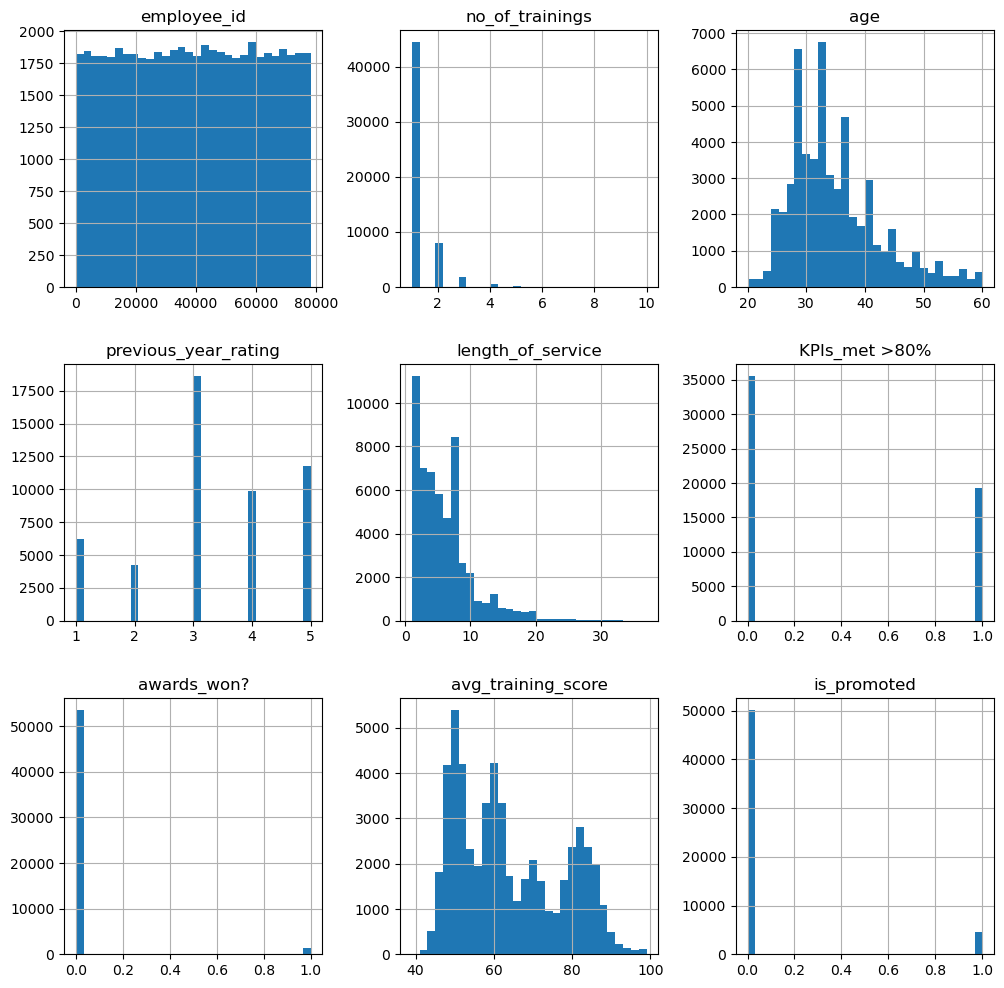

In [12]:
# Histograms of Numerical Features
hr_data.hist(bins=30, figsize=(12,12))
plt.show()

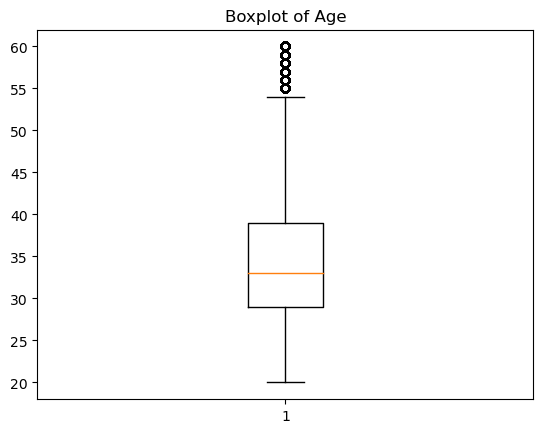

In [13]:
# Boxplot (age)
plt.boxplot(hr_data['age'].dropna())
plt.title('Boxplot of Age')

plt.show()

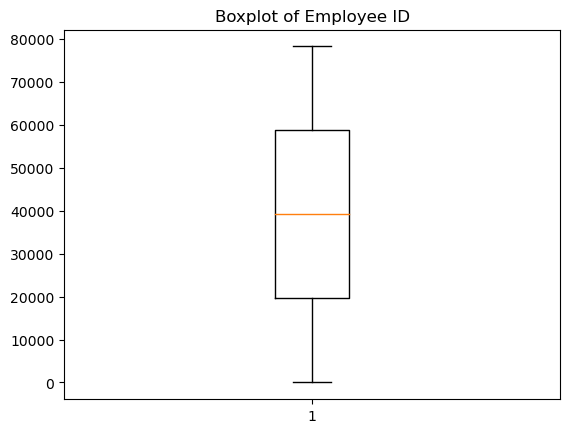

In [14]:
# Boxplot (employee_id)
plt.boxplot(hr_data['employee_id'].dropna())
plt.title('Boxplot of Employee ID')

plt.show()

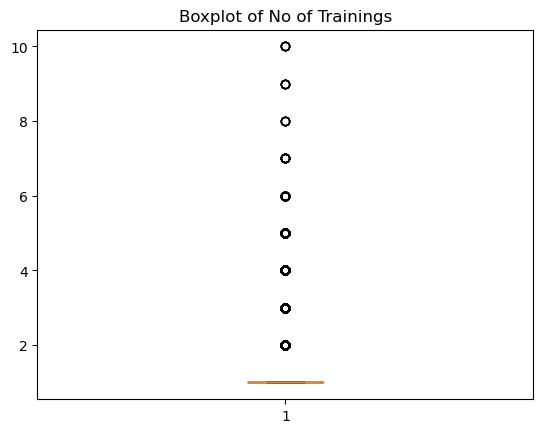

In [15]:
# Boxplot (no_of_trainings)
plt.boxplot(hr_data['no_of_trainings'].dropna())
plt.title('Boxplot of No of Trainings')

plt.show()

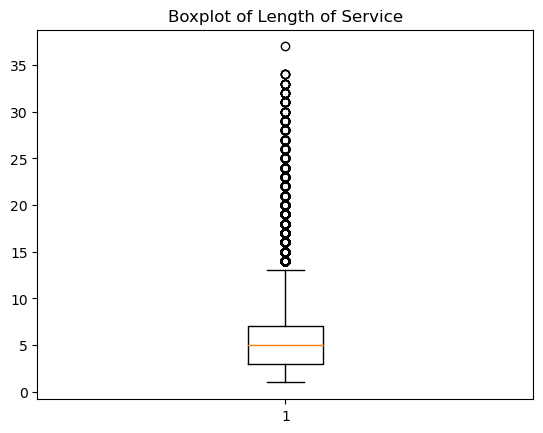

In [16]:
# Boxplot (length_of_service)
plt.boxplot(hr_data['length_of_service'].dropna())
plt.title('Boxplot of Length of Service')

plt.show()

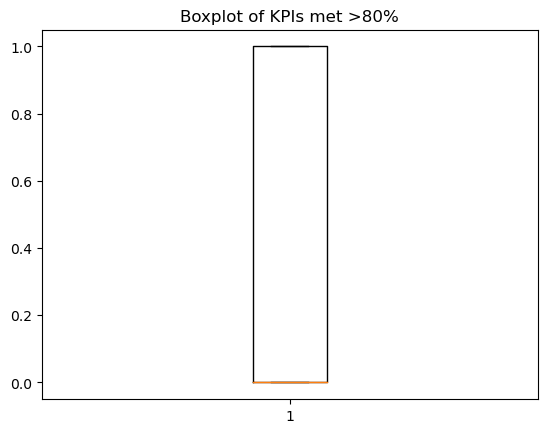

In [17]:
# Boxplot (KPIs_met >80%) (Binary Value)
plt.boxplot(hr_data['KPIs_met >80%'].dropna())
plt.title('Boxplot of KPIs met >80%')

plt.show()

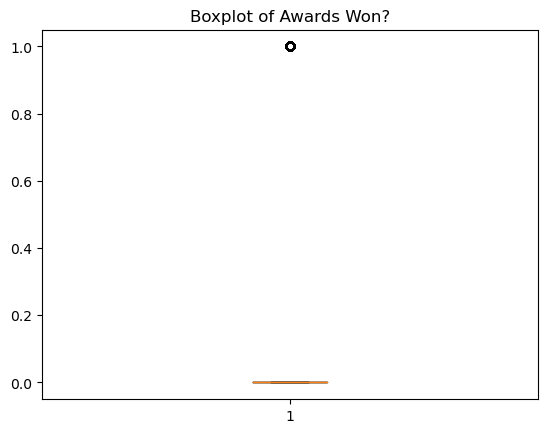

In [18]:
# Boxplot (awards won) (Binary Value)
plt.boxplot(hr_data['awards_won?'].dropna())
plt.title('Boxplot of Awards Won?')

plt.show()

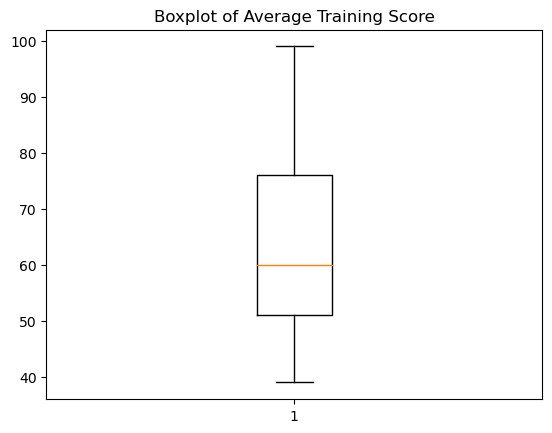

In [19]:
# Boxplot (avg training score)
plt.boxplot(hr_data['avg_training_score'].dropna())
plt.title('Boxplot of Average Training Score')

plt.show()

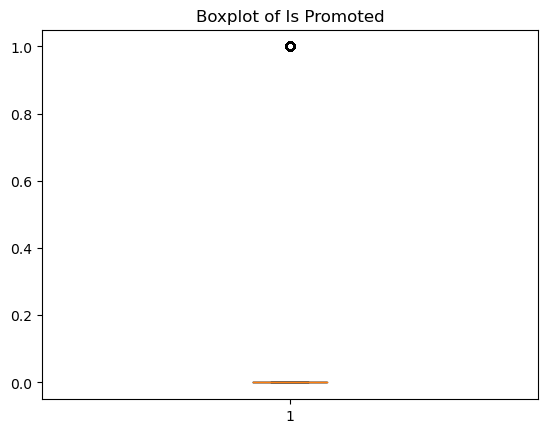

In [20]:
# Boxplot (is promoted) (Binary Value) (Target Variable)
plt.boxplot(hr_data['is_promoted'].dropna())
plt.title('Boxplot of Is Promoted')

plt.show()

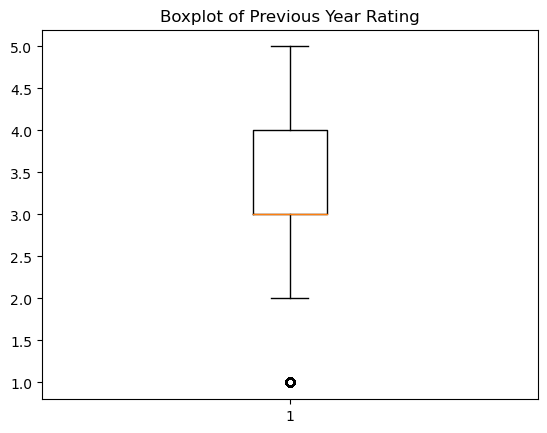

In [21]:
# Boxplot (previous year rating)
plt.boxplot(hr_data['previous_year_rating'].dropna())
plt.title('Boxplot of Previous Year Rating')

plt.show()

#### Exploratory Data Analysis

In [22]:
# Exploratory Analysis
# Explore in relation to the target (is_promoted)
# Does number of training affect promotion? (bar)
# Does education affect promotion? (bar)
# Does length of service affect promotion? (scatter)
# Which region has the most promotions? (bar)
# Which gender has more promotions? (pie)

#### Does number of training affect promotion?

In [23]:
# Dataframe for "does number of training affect promotion?"
df1 = hr_data[['no_of_trainings','is_promoted']].copy()
df1 = df1.groupby(['no_of_trainings']).sum()
df1b = hr_data[['no_of_trainings','is_promoted']].copy()
df1b['is_promoted'] = df1b['is_promoted'].replace(0, 1)
df1b = df1b.groupby(['no_of_trainings']).sum()
df1['promoted %'] = df1['is_promoted'] / df1b['is_promoted'] * 100
df1 = df1.drop(['is_promoted'], axis = 1)
df1.head()

promoted %
no_of_trainings            
1                  8.810672
2                  7.574809
3                  6.869369
4                  5.555556
5                  2.343750

<AxesSubplot:xlabel='no_of_trainings'>

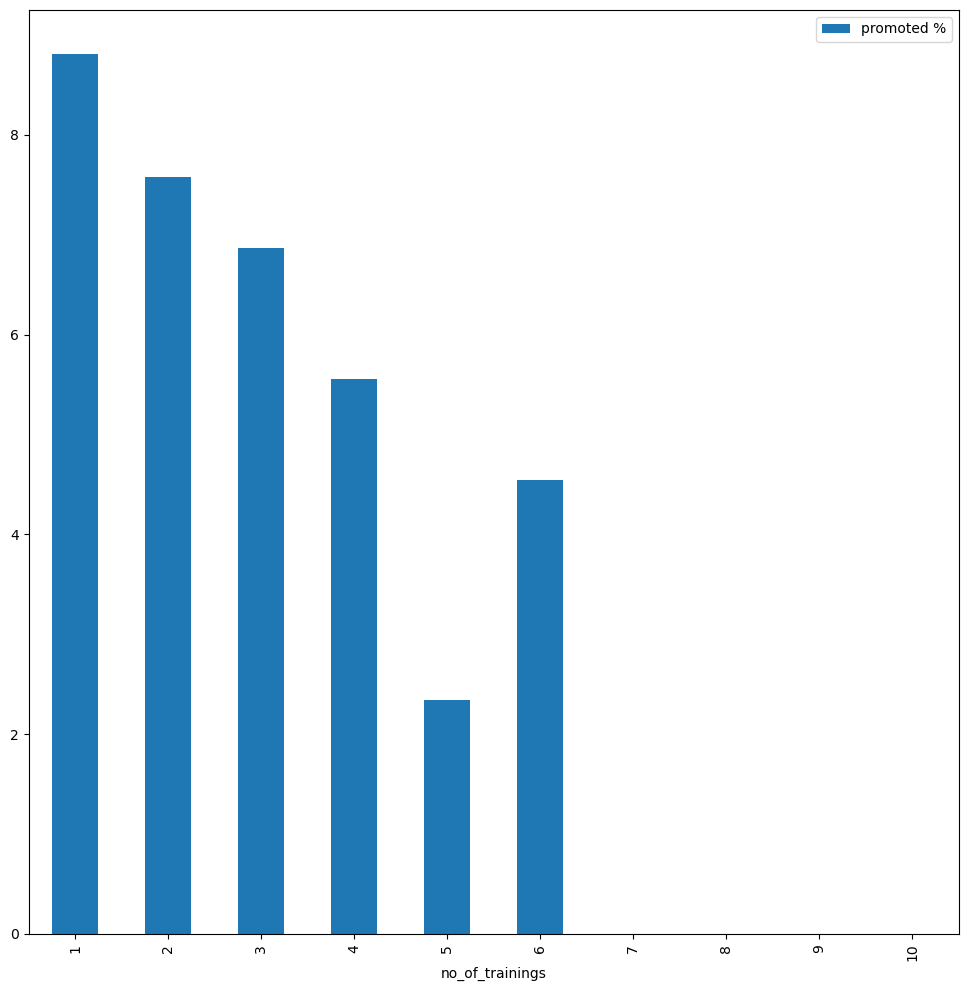

In [24]:
# Does number of training affect promotion? (bar)
df1.plot.bar(figsize=(12, 12))

In [25]:
# Conclusion: Based on the bar chart, it can be observed that the number of trainings is not a key criterion for promotion as many of the employees who were promoted only went through 1 training. 

#### Does education affect promotion?

In [26]:
# Dataframe for "Does education affect promotion?"
df2 = hr_data[['education','is_promoted']].copy()
df2 = df2.groupby(['education']).sum()
df2b = hr_data[['education','is_promoted']].copy()
df2b['is_promoted'] = df2b['is_promoted'].replace(0, 1)
df2b = df2b.groupby(['education']).sum()
df2['promoted %'] = df2['is_promoted'] / df2b['is_promoted'] * 100
df2 = df2.drop(['is_promoted'], axis = 1)
df2 = df2.sort_values('promoted %', ascending=True)
df2.head()

promoted %
education                   
Bachelor's          8.203114
Below Secondary     8.322981
Master's & above    9.855946

<AxesSubplot:ylabel='education'>

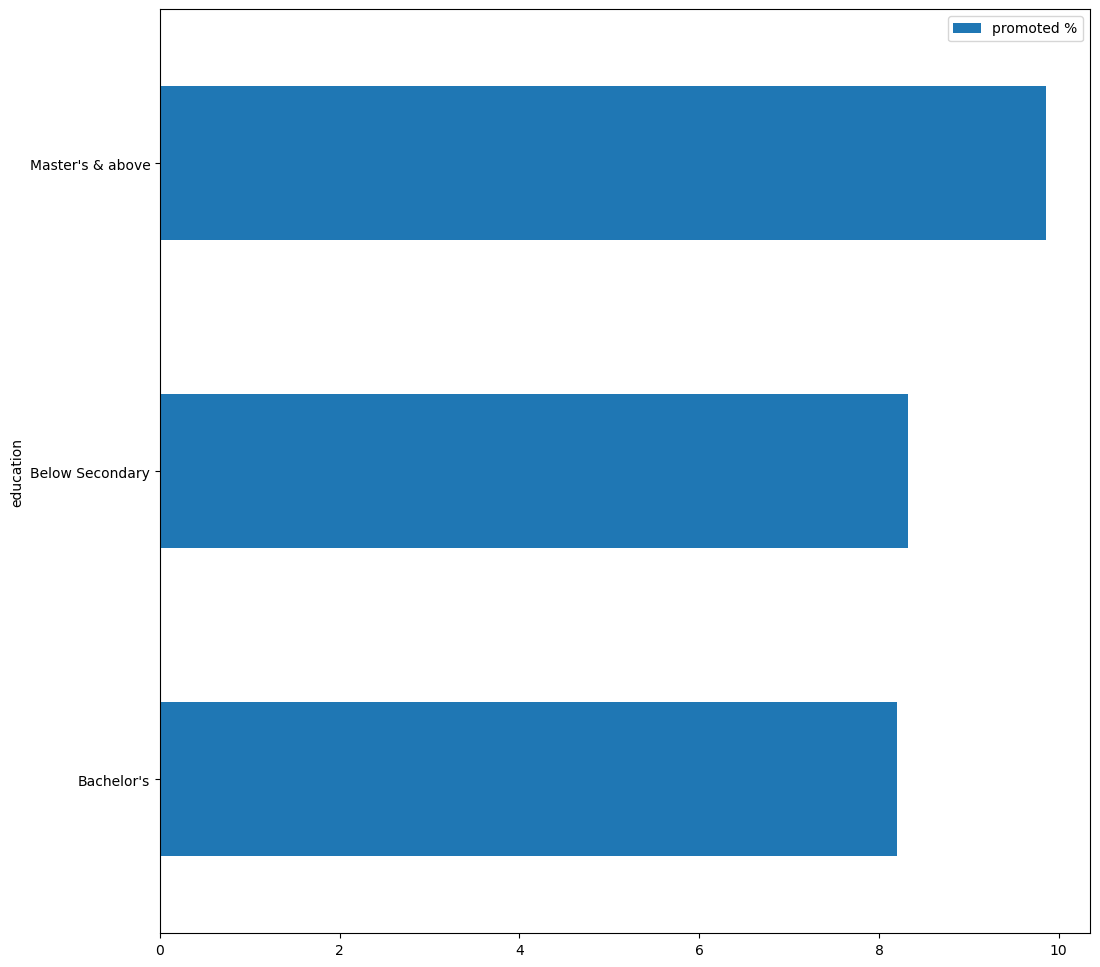

In [27]:
df2.plot.barh(figsize=(12, 12))

In [28]:
# Conclusion: Based on the bar chart, we can see that there is a slightly higher percentage of people who were promoted if they have a Master’s or above. 

#### Does length of service affect promotion?

In [29]:
# Dataframe for "does length of service affect promotion? (scatter)"
df3 = hr_data[['length_of_service','is_promoted']].copy()
df3 = df3.groupby(['length_of_service']).sum()
df3b = hr_data[['length_of_service','is_promoted']].copy()
df3b['is_promoted'] = df3b['is_promoted'].replace(0, 1)
df3b = df3b.groupby(['length_of_service']).sum()
df3['promoted %'] = df3['is_promoted'] / df3b['is_promoted'] * 100
df3 = df3.drop(['is_promoted'], axis = 1)
df3 = df3.sort_values('promoted %', ascending=False)
df3.head(30)

promoted %
length_of_service            
34                  25.000000
32                  20.000000
23                  10.769231
11                  10.480349
29                  10.000000
22                   9.836066
19                   9.726444
8                    9.330558
10                   9.302326
2                    8.901855
4                    8.747806
9                    8.710536
3                    8.659178
6                    8.470638
7                    8.358854
1                    8.291181
5                    8.144719
12                   7.934509
13                   7.860262
20                   7.812500
16                   7.481752
15                   7.251265
28                   6.666667
18                   6.377551
17                   6.018519
14                   5.282332
21                   5.128205
25                   3.921569
27                   2.777778
26                   0.000000

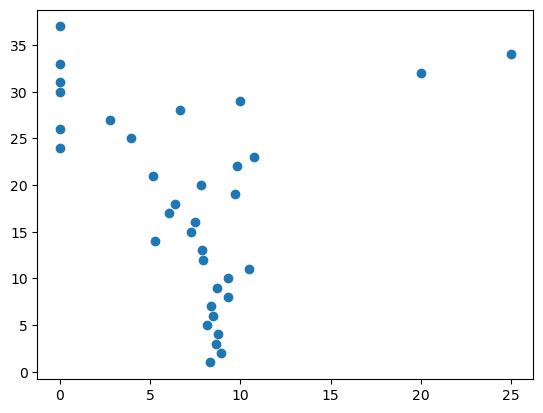

In [30]:
plt.scatter(df3['promoted %'], df3.index)

#### Does age matter for promotion?

In [31]:
# Does age matter for promotion?
df3c = hr_data[['age','is_promoted']].copy()
df3c = df3c.groupby(['age']).sum()
df3d = hr_data[['age','is_promoted']].copy()
df3d['is_promoted'] = df3d['is_promoted'].replace(0, 1)
df3d = df3d.groupby(['age']).sum()
df3c['promoted %'] = df3c['is_promoted'] / df3d['is_promoted'] * 100
df3c = df3c.drop(['is_promoted'], axis = 1)
df3c = df3c.sort_values('promoted %', ascending=False)
df3c.head(30)


promoted %
age            
35    10.438952
33     9.937695
28     9.787099
38     9.568383
39     9.498525
34     9.297789
27     9.232402
30     8.840382
31     8.771930
51     8.740360
29     8.634361
37     8.498845
32     8.404075
24     8.284024
44     8.264463
36     8.263806
59     8.133971
41     8.068270
52     7.977208
56     7.954545
23     7.943925
42     7.919930
26     7.912621
48     7.899461
22     7.792208
43     7.762097
54     7.667732
40     7.636801
58     7.511737
49     7.482993

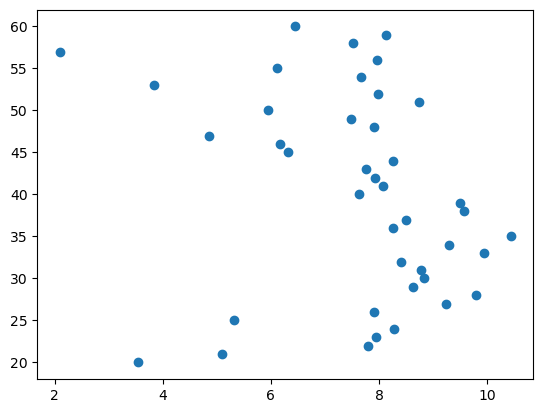

In [32]:
plt.scatter(df3c['promoted %'], df3c.index)

In [33]:
# Conclusion for both scatter: length of service is not a factor when it comes to promotion & Employees at age 35 have the highest chance of getting a promotion. 

#### Which gender has more promotions?

In [34]:
# Dataframe for "Which gender has more promotions?" (pie)
df4 = hr_data[['gender','is_promoted']].copy()
df4 = df4.groupby(['gender']).sum()
df4.head()


is_promoted
gender             
f              1467
m              3201

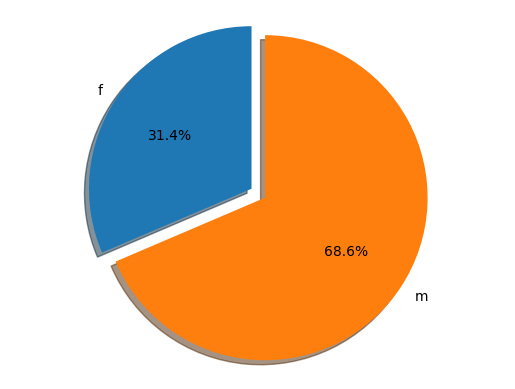

In [35]:
labels = df4.index
value = df4.values.flatten()

explode = (0.1, 0)
fig1, ax4 = plt.subplots()
ax4.pie(value, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax4.axis('equal')

plt.show()

In [36]:
# Number of males and females for context
hr_data['gender'].value_counts()

m    38496
f    16312
Name: gender, dtype: int64

In [37]:
# Conclusion: As a whole, there are more males than females in this company, the number of males who obtained a promotion is greater than females.

#### Top 10 region that has the most promotions?

In [38]:
# Dataframe "top region has the most promotions?" (bar)
df5 = hr_data[['region','is_promoted']].copy()
df5 = df5.groupby(['region']).sum()
df5 = df5.sort_values('is_promoted', ascending=False).head(5)
df5.head(10)

is_promoted
region                
region_2           989
region_22          734
region_7           516
region_4           246
region_13          230

<AxesSubplot:xlabel='region'>

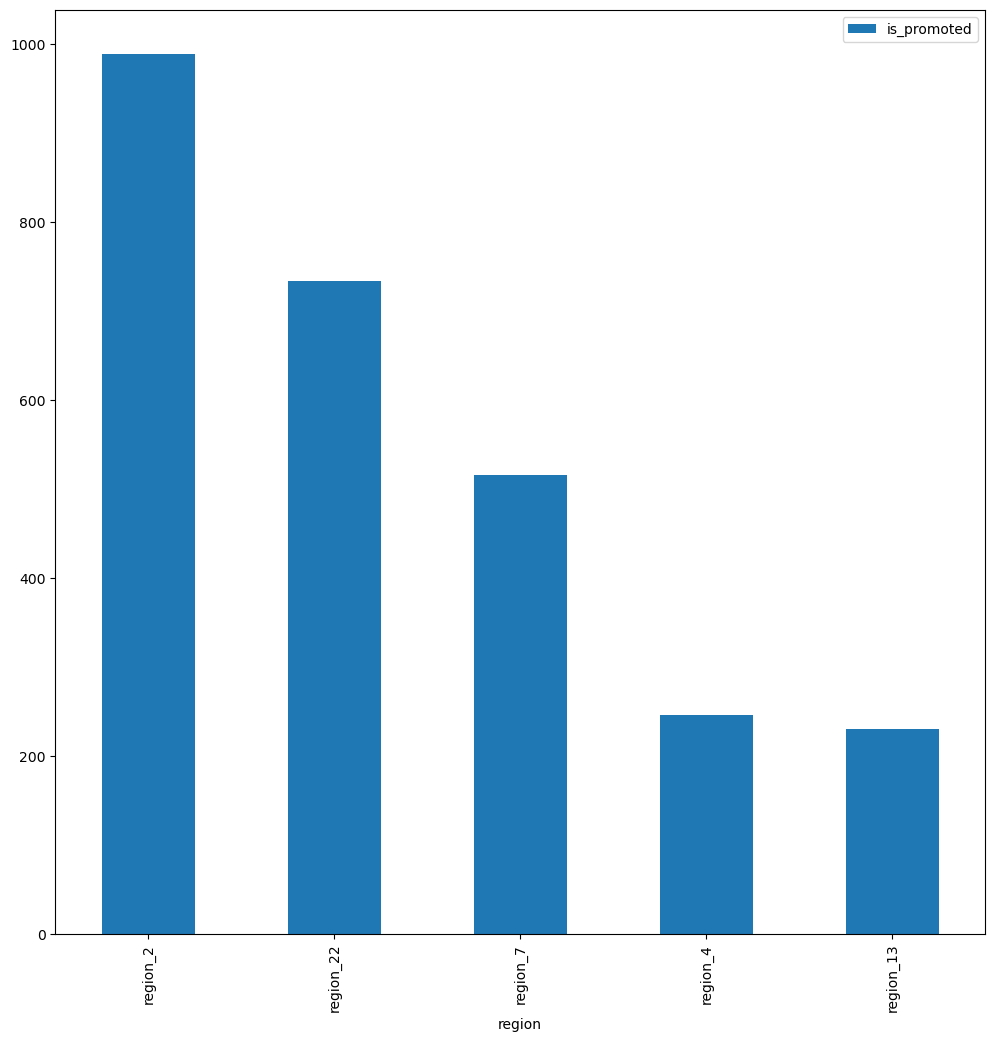

In [39]:
df5.plot.bar(figsize=(12, 12))

In [40]:
# Conclusion: Based on the bar chart, “region_2” has the most promotions among the other regions, 
# which may indicate that region 2 has better performing employees or more employees than the other regions.

#### Does Training Score Impact Promotion?

<AxesSubplot:xlabel='avg_training_score'>

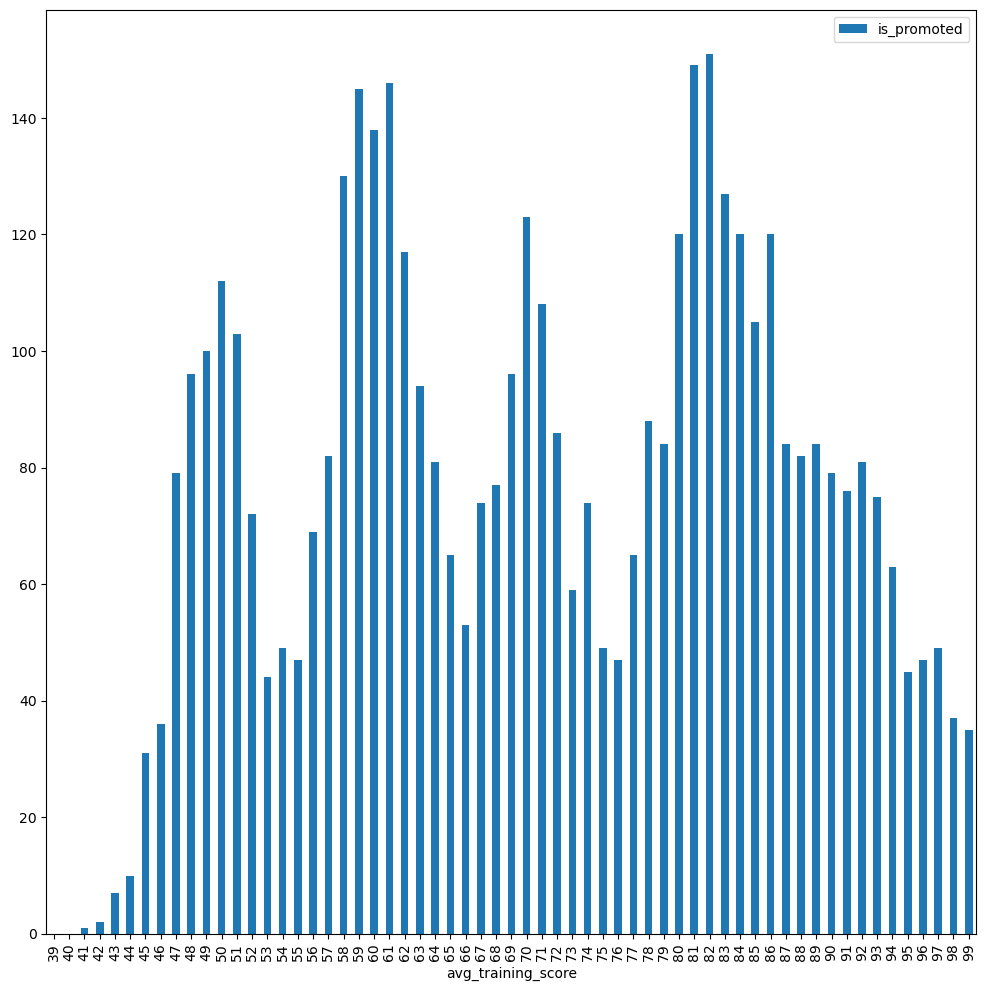

In [41]:
# Training score vs is_promoted
df6 = hr_data[['avg_training_score','is_promoted']].copy()
df6 = df6.groupby('avg_training_score').sum()
#df6 = df6.sort_values('is_promoted', ascending=False)
df6.plot.bar(figsize=(12, 12))

In [42]:
# Conclusion: Based on the bar chart, we can see that there are typically more promotions for employees who have a higher average training score. 
# This indicates that the feature will be helpful as a predictor on the target.

#### Correlation of Features (Before Transformation)

In [43]:
# Correlation before Transformation
# Inspect Correlation of features
hr_data.corr()

employee_id  no_of_trainings       age  \
employee_id              1.000000        -0.005121  0.000437   
no_of_trainings         -0.005121         1.000000 -0.081278   
age                      0.000437        -0.081278  1.000000   
previous_year_rating     0.004533        -0.063126  0.006008   
length_of_service        0.001274        -0.057275  0.657111   
KPIs_met >80%           -0.002501        -0.045576 -0.025592   
awards_won?              0.008420        -0.007628 -0.008169   
avg_training_score      -0.000586         0.042517 -0.048380   
is_promoted              0.001206        -0.024896 -0.017166   

                      previous_year_rating  length_of_service  KPIs_met >80%  \
employee_id                       0.004533           0.001274      -0.002501   
no_of_trainings                  -0.063126          -0.057275      -0.045576   
age                               0.006008           0.657111      -0.025592   
previous_year_rating              1.000000           0.000253       0.351578   
length_of_service                 0.000253           1.000000      -0.077693   
KPIs_met >80%                     0.351578          -0.077693       1.000000   
awards_won?                       0.027738          -0.039927       0.097000   
avg_training_score                0.075139          -0.038122       0.078391   
is_promoted                       0.159320          -0.010670       0.221582   

                      awards_won?  avg_training_score  is_promoted  
employee_id              0.008420           -0.000586     0.001206  
no_of_trainings         -0.007628            0.042517    -0.024896  
age                     -0.008169           -0.048380    -0.017166  
previous_year_rating     0.027738            0.075139     0.159320  
length_of_service       -0.039927           -0.038122    -0.010670  
KPIs_met >80%            0.097000            0.078391     0.221582  
awards_won?              1.000000            0.072138     0.195871  
avg_training_score       0.072138            1.000000     0.181147  
is_promoted              0.195871            0.181147     1.000000

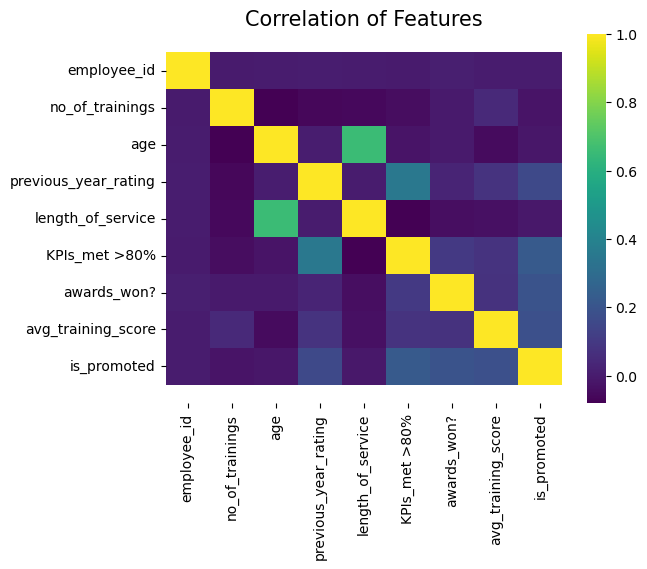

In [44]:
# Build a heatmap to visualize correlation
colormap = plt.cm.viridis
#plt.figure(figsize=(20,20))
plt.title('Correlation of Features', size=15)
ax = sns.heatmap(hr_data.corr(), cmap=colormap, annot=False)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

#### Value Based Problem Statement

Predict if an employee will get promoted based on their records.

### 1.2 Cleanse and Transform the data

#### Perform Stratified Sampling

In [45]:
# Check values of target.
# Larger proportion of 0s to 1s
# Stratified Sampling is done to ensure we properly represent the subgroups that are present in the data.
# Even distribution of the target
hr_data['is_promoted'].value_counts()

0    50140
1     4668
Name: is_promoted, dtype: int64

In [46]:
df1=hr_data[hr_data['is_promoted']==1]
df1.head()

employee_id         department     region         education gender  \
11        49017  Sales & Marketing   region_7        Bachelor's      f   
39        58304  Sales & Marketing  region_28        Bachelor's      m   
60        17673  Sales & Marketing   region_4  Master's & above      m   
66        77981            Finance  region_22        Bachelor's      m   
67        16502  Sales & Marketing  region_22        Bachelor's      m   

   recruitment_channel  no_of_trainings  age  previous_year_rating  \
11            sourcing                1   35                   5.0   
39            sourcing                1   33                   5.0   
60               other                1   50                   4.0   
66               other                1   27                   NaN   
67            sourcing                1   27                   NaN   

    length_of_service  KPIs_met >80%  awards_won?  avg_training_score  \
11                  3              1            0                  50   
39                  6              1            0                  51   
60                 17              1            0                  47   
66                  1              1            1                  58   
67                  1              0            0                  61   

    is_promoted  
11            1  
39            1  
60            1  
66            1  
67            1

In [47]:
len(df1)

4668

In [48]:
df0=hr_data[hr_data['is_promoted']==0]
df0.head()

employee_id         department     region         education gender  \
0        65438  Sales & Marketing   region_7  Master's & above      f   
1        65141         Operations  region_22        Bachelor's      m   
2         7513  Sales & Marketing  region_19        Bachelor's      m   
3         2542  Sales & Marketing  region_23        Bachelor's      m   
4        48945         Technology  region_26        Bachelor's      m   

  recruitment_channel  no_of_trainings  age  previous_year_rating  \
0            sourcing                1   35                   5.0   
1               other                1   30                   5.0   
2            sourcing                1   34                   3.0   
3               other                2   39                   1.0   
4               other                1   45                   3.0   

   length_of_service  KPIs_met >80%  awards_won?  avg_training_score  \
0                  8              1            0                  49   
1                  4              0            0                  60   
2                  7              0            0                  50   
3                 10              0            0                  50   
4                  2              0            0                  73   

   is_promoted  
0            0  
1            0  
2            0  
3            0  
4            0

In [49]:
len(df0)

50140

In [50]:
df0_sampled = df0.sample(n=len(df1), random_state=2).copy()
df0_sampled.info()
# Make df0 equal to df1

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4668 entries, 6725 to 12976
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           4668 non-null   int64  
 1   department            4668 non-null   object 
 2   region                4668 non-null   object 
 3   education             4438 non-null   object 
 4   gender                4668 non-null   object 
 5   recruitment_channel   4668 non-null   object 
 6   no_of_trainings       4668 non-null   int64  
 7   age                   4668 non-null   int64  
 8   previous_year_rating  4305 non-null   float64
 9   length_of_service     4668 non-null   int64  
 10  KPIs_met >80%         4668 non-null   int64  
 11  awards_won?           4668 non-null   int64  
 12  avg_training_score    4668 non-null   int64  
 13  is_promoted           4668 non-null   int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 547.0+ KB


In [51]:
hr_data=pd.concat([df1,df0_sampled],axis=0) # joining tables
hr_data['is_promoted'].value_counts()

1    4668
0    4668
Name: is_promoted, dtype: int64

In [52]:
# Check new dataframe
hr_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9336 entries, 11 to 12976
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           9336 non-null   int64  
 1   department            9336 non-null   object 
 2   region                9336 non-null   object 
 3   education             8984 non-null   object 
 4   gender                9336 non-null   object 
 5   recruitment_channel   9336 non-null   object 
 6   no_of_trainings       9336 non-null   int64  
 7   age                   9336 non-null   int64  
 8   previous_year_rating  8634 non-null   float64
 9   length_of_service     9336 non-null   int64  
 10  KPIs_met >80%         9336 non-null   int64  
 11  awards_won?           9336 non-null   int64  
 12  avg_training_score    9336 non-null   int64  
 13  is_promoted           9336 non-null   int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 1.1+ MB


In [53]:
hr_data.describe()

employee_id  no_of_trainings          age  previous_year_rating  \
count   9336.000000      9336.000000  9336.000000           8634.000000   
mean   38869.959940         1.228685    34.596937              3.626940   
std    22642.619782         0.567723     7.449845              1.211617   
min       15.000000         1.000000    20.000000              1.000000   
25%    19135.500000         1.000000    29.000000              3.000000   
50%    38955.500000         1.000000    33.000000              4.000000   
75%    58222.750000         1.000000    38.000000              5.000000   
max    78292.000000         7.000000    60.000000              5.000000   

       length_of_service  KPIs_met >80%  awards_won?  avg_training_score  \
count        9336.000000    9336.000000  9336.000000         9336.000000   
mean            5.759533       0.508569     0.066945           67.104863   
std             4.146011       0.499953     0.249940           14.569584   
min             1.000000       0.000000     0.000000           41.000000   
25%             3.000000       0.000000     0.000000           54.000000   
50%             5.000000       1.000000     0.000000           65.000000   
75%             7.000000       1.000000     0.000000           81.000000   
max            34.000000       1.000000     1.000000           99.000000   

       is_promoted  
count  9336.000000  
mean      0.500000  
std       0.500027  
min       0.000000  
25%       0.000000  
50%       0.500000  
75%       1.000000  
max       1.000000

#### Drop Irrelevant Features

In [54]:
hr_data = hr_data.drop(['length_of_service', 'employee_id'], axis = 1)
hr_data.head()
# length of service and age are strongly correlated. (may provide the same value to the model)
# Keep age as it is a better feature for prediction based on EDA
# Employee ID has little relevance to target

department     region         education gender recruitment_channel  \
11  Sales & Marketing   region_7        Bachelor's      f            sourcing   
39  Sales & Marketing  region_28        Bachelor's      m            sourcing   
60  Sales & Marketing   region_4  Master's & above      m               other   
66            Finance  region_22        Bachelor's      m               other   
67  Sales & Marketing  region_22        Bachelor's      m            sourcing   

    no_of_trainings  age  previous_year_rating  KPIs_met >80%  awards_won?  \
11                1   35                   5.0              1            0   
39                1   33                   5.0              1            0   
60                1   50                   4.0              1            0   
66                1   27                   NaN              1            1   
67                1   27                   NaN              0            0   

    avg_training_score  is_promoted  
11                  50            1  
39                  51            1  
60                  47            1  
66                  58            1  
67                  61            1

#### Handle Missing Values

In [55]:
# Checking Missing Values

In [56]:
# Missing Values in Categorical Columns
cat_cols = [c for c in hr_data.columns if hr_data[c].dtypes=='O']
hr_data[cat_cols].isnull().mean().sort_values()

department             0.000000
region                 0.000000
gender                 0.000000
recruitment_channel    0.000000
education              0.037704
dtype: float64

In [57]:
# Missing Values in Numerical Columns
num_cols = [c for c in hr_data.columns if hr_data[c].dtypes !='O']
hr_data[num_cols].isnull().mean().sort_values()

no_of_trainings         0.000000
age                     0.000000
KPIs_met >80%           0.000000
awards_won?             0.000000
avg_training_score      0.000000
is_promoted             0.000000
previous_year_rating    0.075193
dtype: float64

In [58]:
# list with numerical varibles (median) and categorical variables (missing). 
features_num_median = ['previous_year_rating'] # assume new hires start at middle rating (0 may mean a poor rating when they join)
features_cat_missing = ['education'] # missing from dataset (cannot assume)

In [59]:
# instantiate imputer

# feature list & imputer into column transformer
pipe = Pipeline(steps=[
    ('imp_num_median', mdi.MeanMedianImputer(imputation_method = 'median', variables=features_num_median)),
    ('imp_cat_missing', mdi.CategoricalImputer(variables=features_cat_missing, imputation_method='missing'))
])

# fit preprocessor
pipe.fit(hr_data)

# impute data
hr_data = pipe.transform(hr_data)

In [60]:
# Check for nulls after impute
hr_data.isnull().sum().sort_values()

department              0
region                  0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age                     0
previous_year_rating    0
KPIs_met >80%           0
awards_won?             0
avg_training_score      0
is_promoted             0
dtype: int64

#### Handle Outliers

In [61]:
# define function for diagnostic 
def diagnostic_plots(df, variable):
    # dataframe and a variable are used as arguments to generate the plots

    # Figure size
    plt.figure(figsize=(16, 4))
    plt.suptitle('{}'.format(variable), fontsize=16) #set variable as title

    # Histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Sample Quantiles')

    # Box-Plot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

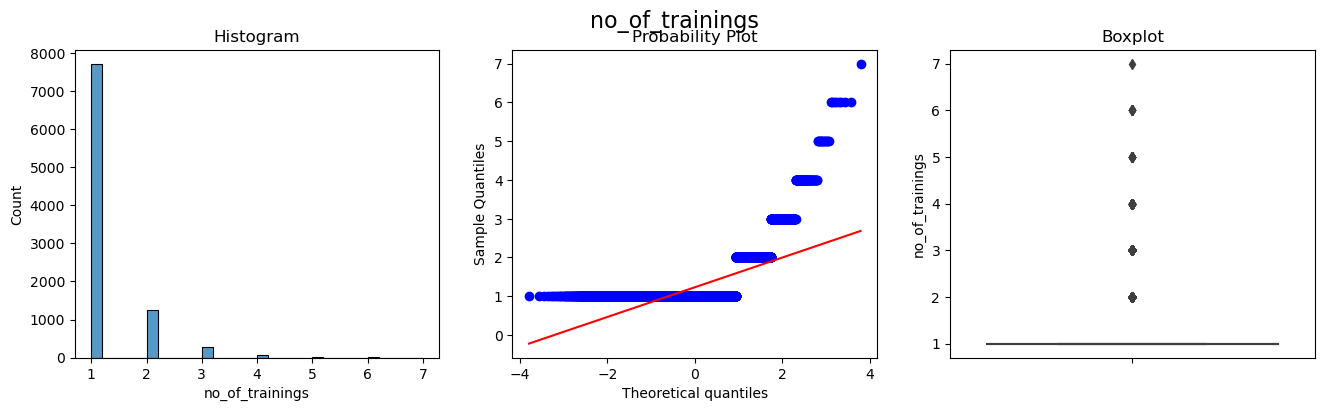

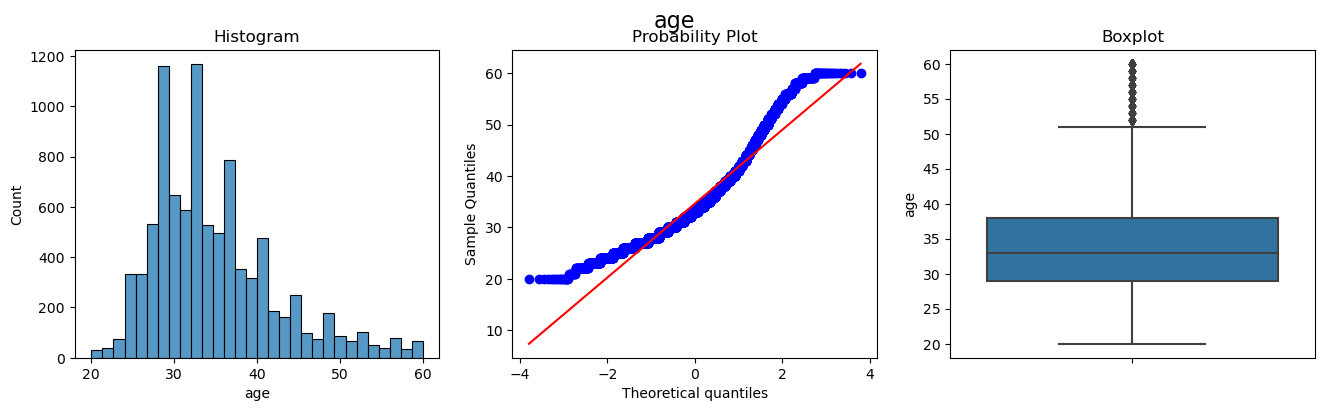

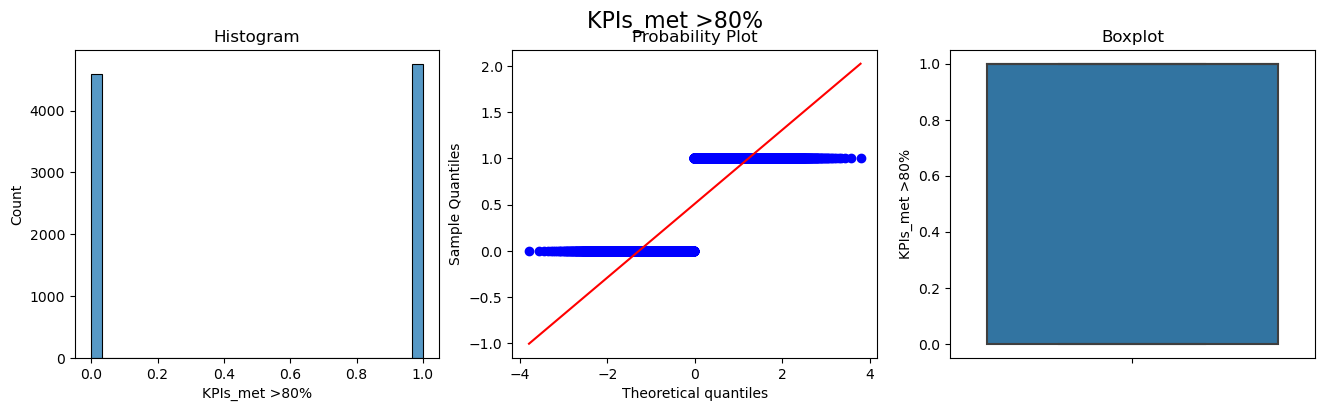

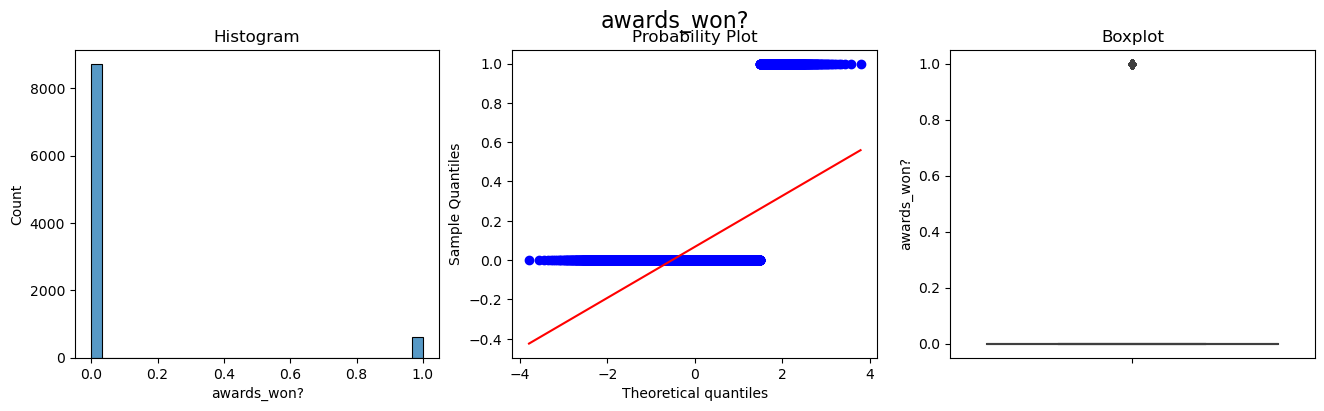

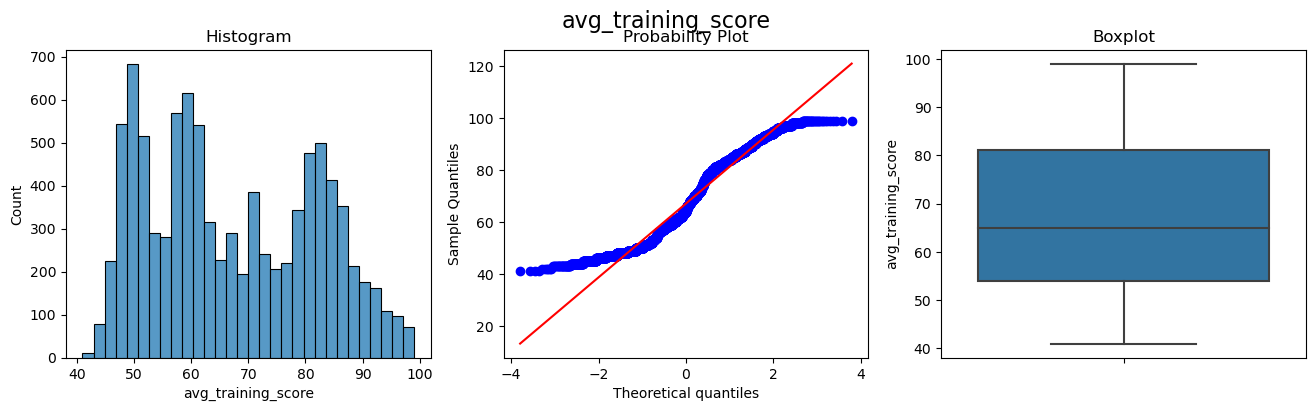

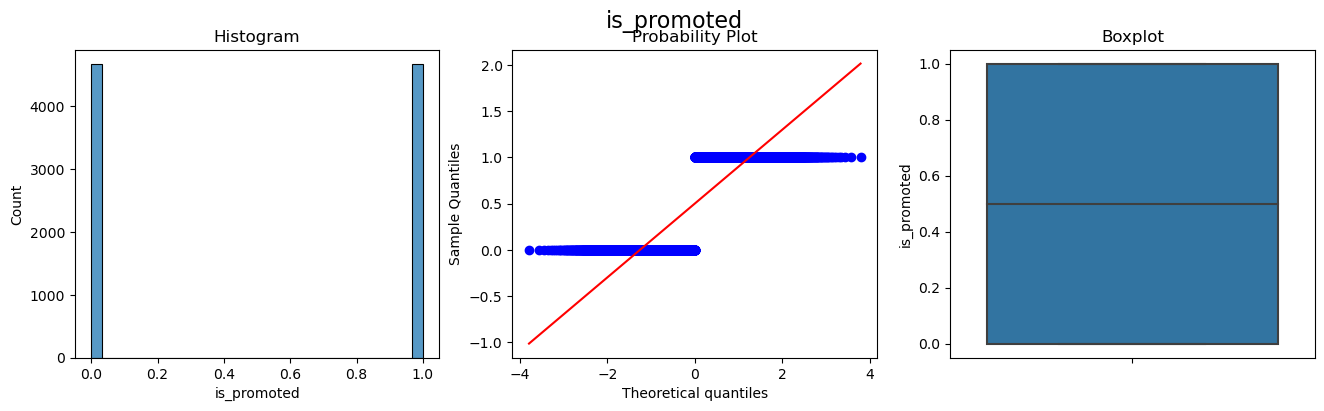

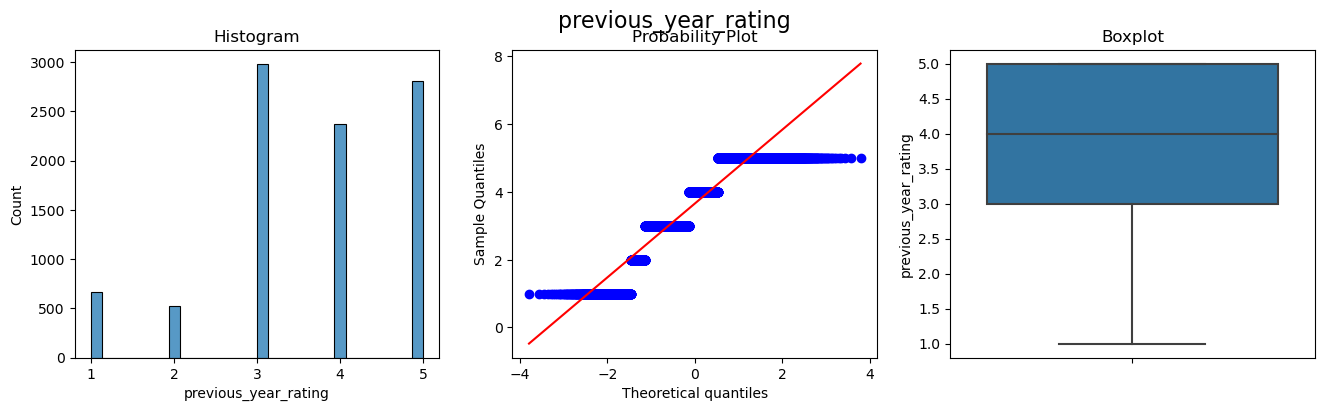

In [62]:
# diagnostic_plot
diagnostic_plots(hr_data, 'no_of_trainings')
diagnostic_plots(hr_data, 'age')
diagnostic_plots(hr_data, 'KPIs_met >80%')
diagnostic_plots(hr_data, 'awards_won?')
diagnostic_plots(hr_data, 'avg_training_score')
diagnostic_plots(hr_data, 'is_promoted')
diagnostic_plots(hr_data, 'previous_year_rating')

In [63]:
# Determine Which features to perform outlier handling
# Ignore Binary Features (is_promoted, awards_won?, KPIs_met >80%)
# Outlier Handling only on "age", "avg_training_score", "previous_year_rating", "no_of_trainings"

In [64]:
# Use Capping (gaussian) (affects accuracy)
windsorizer = Winsorizer(capping_method ='gaussian', 
                        tail='right', fold = 2, 
                         variables=["avg_training_score", "age", 
                                    "previous_year_rating", "no_of_trainings"
                                   ])

windsorizer.fit(hr_data)
hr_data_t = windsorizer.transform(hr_data)

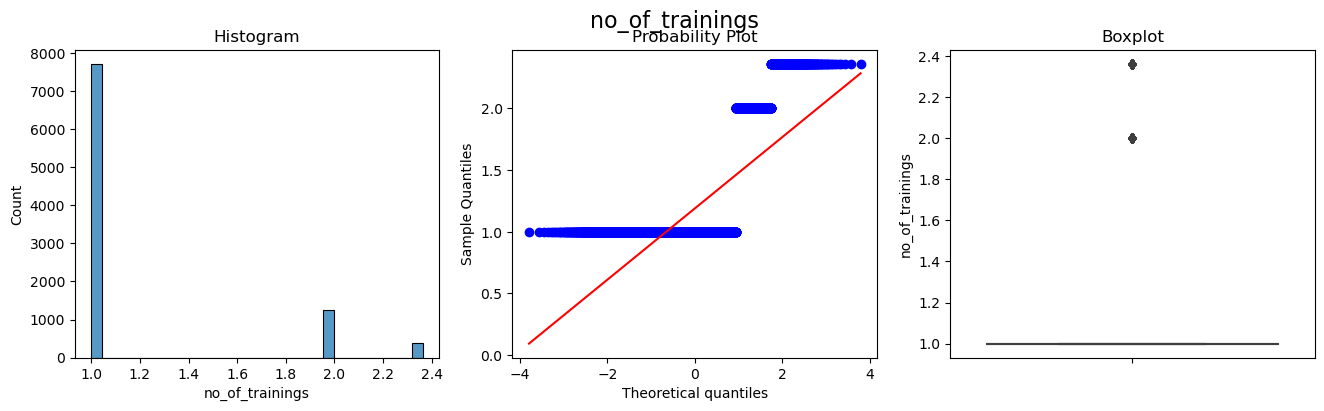

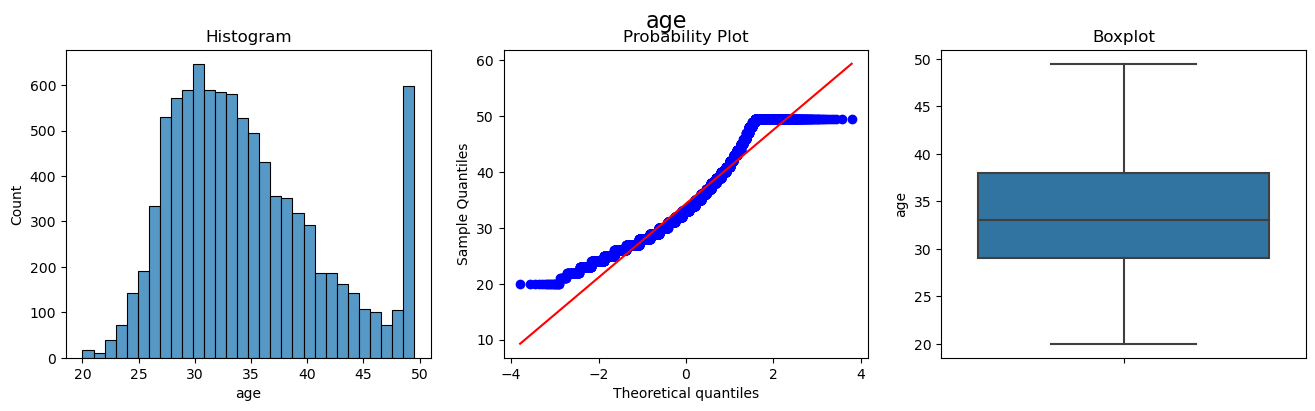

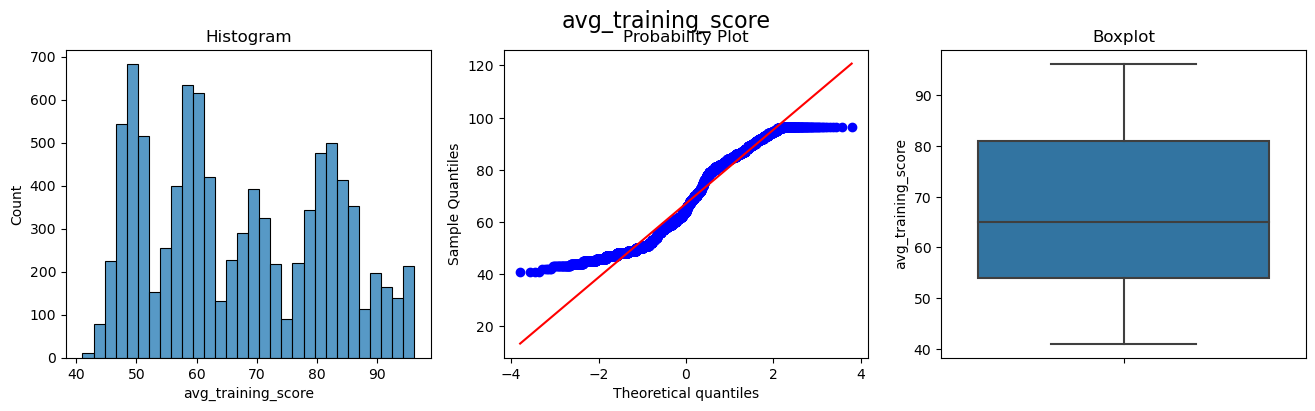

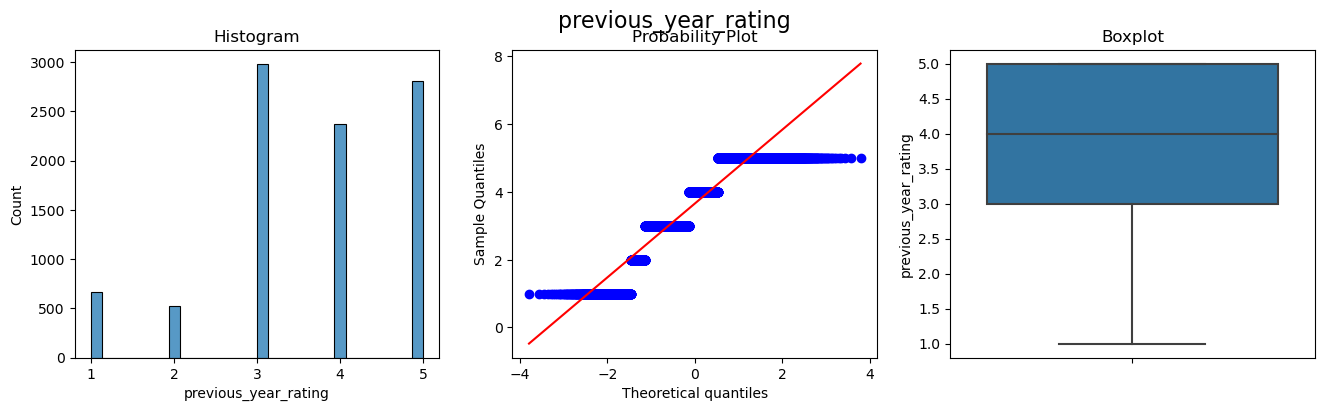

In [65]:
# Observe after outlier handling
diagnostic_plots(hr_data_t, 'no_of_trainings')
diagnostic_plots(hr_data_t, 'age')
diagnostic_plots(hr_data_t, 'avg_training_score')
diagnostic_plots(hr_data_t, 'previous_year_rating')

#### Train Test Split

In [66]:
# Split the dataset into training (70%) and testing (30%)
# Target variable: Item_Outlet_Sales
hr_X_train, hr_X_test, hr_y_train, hr_y_test = train_test_split(
    hr_data_t.drop(labels=['is_promoted'], axis=1),  # predictors
    hr_data_t['is_promoted'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=14)  # seed ensures reproducibility

hr_X_train.shape, hr_X_test.shape

((6535, 11), (2801, 11))

In [67]:
# Check columns

In [68]:
# train
hr_X_train_im = hr_X_train
hr_X_test_im = hr_X_test 

#### Data Transformation

#### Numerical Transformation

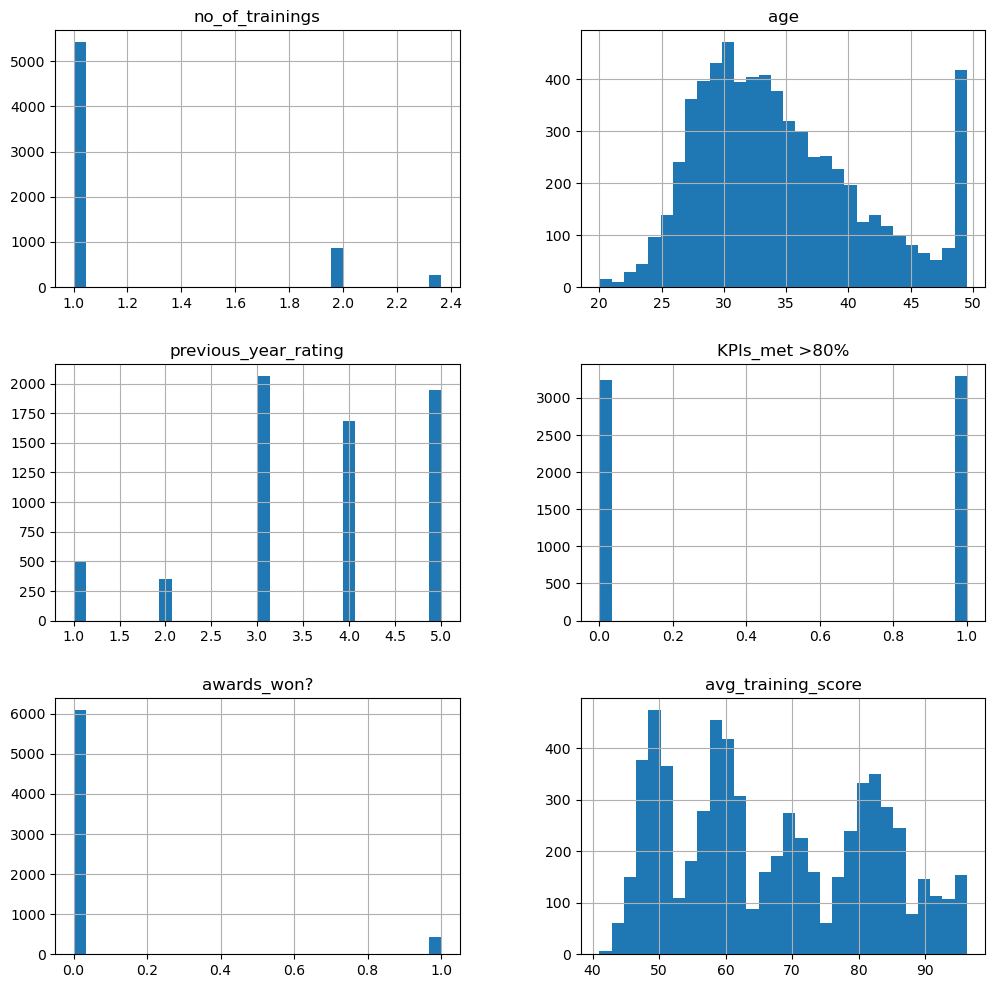

In [69]:
# Numerical Features
hr_X_train_im.hist(bins=30, figsize=(12,12))
plt.show()

In [70]:
# Numerical Transformation (Power Transformer)

t = PowerTransformer(variables= ['no_of_trainings','age',
                                 'KPIs_met >80%','awards_won?','avg_training_score','previous_year_rating'
], exp=1/3)

# fit transformer to data set
t.fit(hr_X_train_im)

# transform on train and test
hr_X_train_nt = t.transform(hr_X_train_im)
hr_X_test_nt = t.transform(hr_X_test_im)

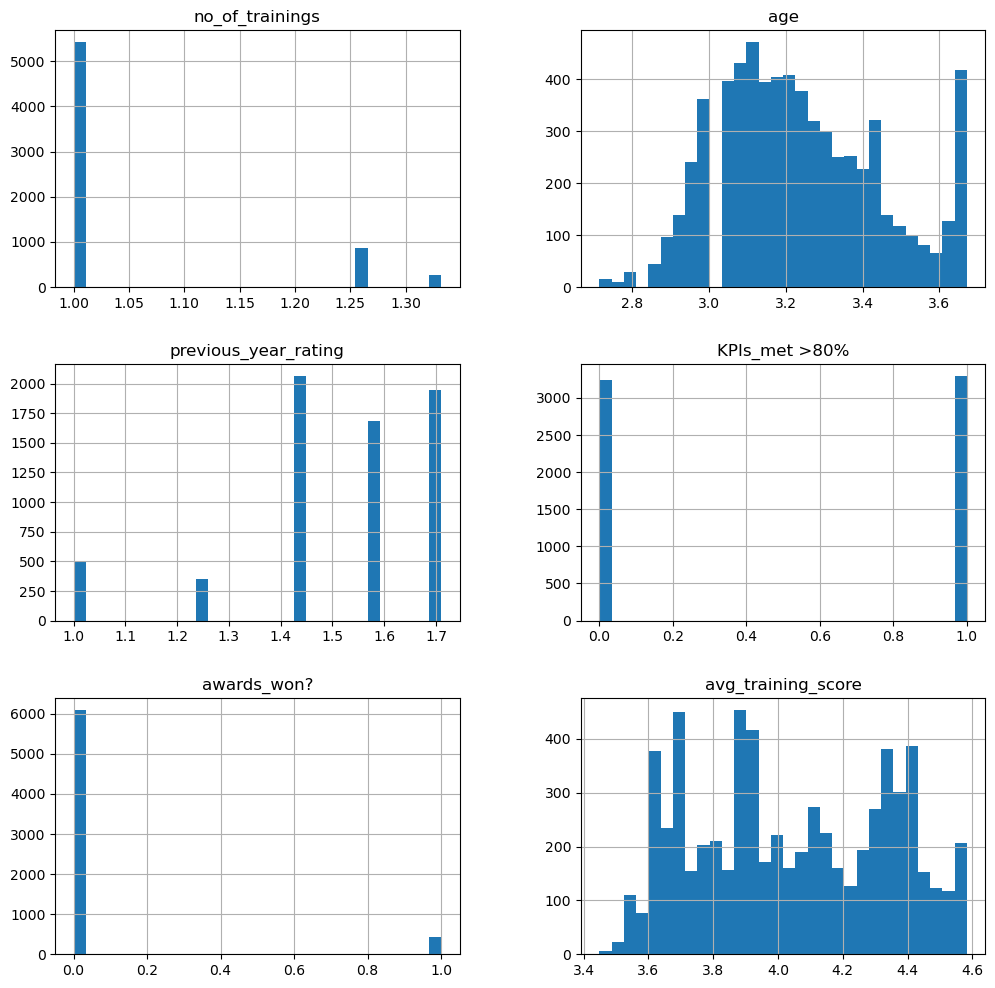

In [71]:
# Observe after transformation
hr_X_train_nt.hist(bins=30, figsize=(12,12))
plt.show()

#### Categorical Transformation

In [72]:
# Categorical Features
# Features: 'department', 'region', 'gender', 'recruitment_channel', 'education'
# One-Hot-Encoding
# create the encoder
ohe_enc = OneHotEncoder(drop_last=False)  # false to return k (better to not drop [False])

In [73]:
# fit the encoder
ohe_enc.fit(hr_X_train_nt)

OneHotEncoder()

In [74]:
hr_X_train_enc = ohe_enc.transform(hr_X_train_nt)
hr_X_test_enc = ohe_enc.transform(hr_X_test_nt)

In [75]:
hr_X_train_enc.head()

no_of_trainings       age  previous_year_rating  KPIs_met >80%  \
8032          1.000000  3.530348              1.587401            1.0   
32675         1.000000  3.671627              1.442250            0.0   
16546         1.000000  3.174802              1.259921            0.0   
43038         1.000000  3.530348              1.442250            0.0   
14612         1.259921  3.583048              1.709976            1.0   

       awards_won?  avg_training_score  department_Operations  \
8032           0.0            3.936497                      1   
32675          0.0            4.396830                      0   
16546          0.0            3.870877                      1   
43038          0.0            3.936497                      1   
14612          0.0            4.101566                      0   

       department_Analytics  department_Procurement  department_Technology  \
8032                      0                       0                      0   
32675                     1                       0                      0   
16546                     0                       0                      0   
43038                     0                       0                      0   
14612                     0                       1                      0   

       ...  region_region_33  education_Master's & above  \
8032   ...                 0                           1   
32675  ...                 0                           0   
16546  ...                 0                           0   
43038  ...                 0                           0   
14612  ...                 0                           1   

       education_Bachelor's  education_Missing  education_Below Secondary  \
8032                      0                  0                          0   
32675                     1                  0                          0   
16546                     1                  0                          0   
43038                     1                  0                          0   
14612                     0                  0                          0   

       gender_f  gender_m  recruitment_channel_other  \
8032          1         0                          1   
32675         0         1                          1   
16546         0         1                          1   
43038         1         0                          0   
14612         1         0                          1   

       recruitment_channel_sourcing  recruitment_channel_referred  
8032                              0                             0  
32675                             0                             0  
16546                             0                             0  
43038                             1                             0  
14612                             0                             0  

[5 rows x 58 columns]

In [76]:
hr_X_test_enc.head()

no_of_trainings       age  previous_year_rating  KPIs_met >80%  \
51020         1.000000  3.271066              1.709976            0.0   
16397         1.000000  2.924018              1.709976            0.0   
9967          1.000000  3.141381              1.709976            1.0   
29046         1.000000  3.141381              1.442250            1.0   
21421         1.332162  3.000000              1.000000            0.0   

       awards_won?  avg_training_score  department_Operations  \
51020          0.0            3.756286                      0   
16397          0.0            3.732511                      0   
9967           0.0            3.936497                      0   
29046          0.0            3.684031                      0   
21421          0.0            3.957892                      0   

       department_Analytics  department_Procurement  department_Technology  \
51020                     0                       0                      0   
16397                     0                       0                      0   
9967                      0                       0                      0   
29046                     0                       0                      0   
21421                     0                       0                      0   

       ...  region_region_33  education_Master's & above  \
51020  ...                 0                           0   
16397  ...                 0                           0   
9967   ...                 0                           0   
29046  ...                 0                           0   
21421  ...                 0                           0   

       education_Bachelor's  education_Missing  education_Below Secondary  \
51020                     1                  0                          0   
16397                     1                  0                          0   
9967                      1                  0                          0   
29046                     0                  1                          0   
21421                     1                  0                          0   

       gender_f  gender_m  recruitment_channel_other  \
51020         1         0                          1   
16397         0         1                          1   
9967          0         1                          0   
29046         0         1                          0   
21421         1         0                          0   

       recruitment_channel_sourcing  recruitment_channel_referred  
51020                             0                             0  
16397                             0                             0  
9967                              1                             0  
29046                             1                             0  
21421                             1                             0  

[5 rows x 58 columns]

#### Feature Scaling

In [77]:
# set up the scaler
scaler = StandardScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(hr_X_train_enc)

# transform train and test sets
X_train_final = scaler.transform(hr_X_train_enc)
X_test_final = scaler.transform(hr_X_test_enc)
X_train_final.shape, X_test_final.shape

((6535, 58), (2801, 58))

In [78]:
# array to dataframe
X_train_final = pd.DataFrame(X_train_final, columns=hr_X_train_enc.columns)
X_test_final = pd.DataFrame(X_test_final, columns=hr_X_train_enc.columns)

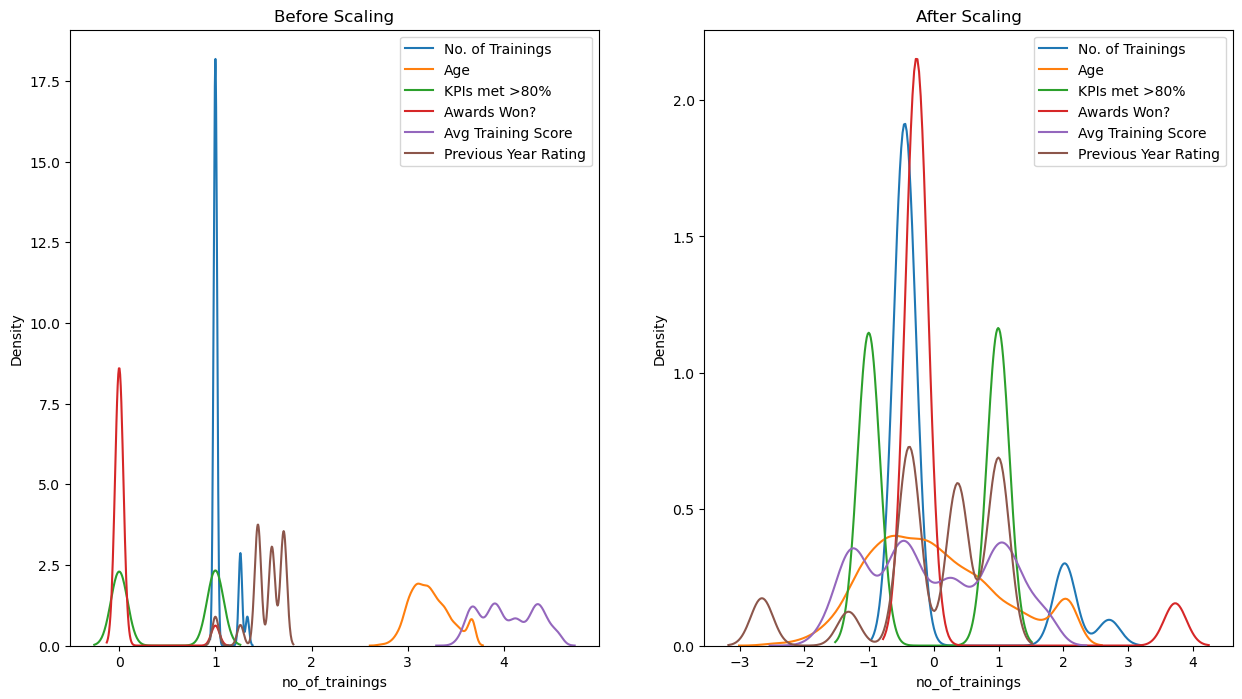

In [79]:
# Visualise before and after scaling
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 8))

# before
ax1.set_title('Before Scaling')
sns.kdeplot(hr_X_train_enc['no_of_trainings'], ax=ax1, label ='No. of Trainings')
sns.kdeplot(hr_X_train_enc['age'], ax=ax1, label ='Age')
sns.kdeplot(hr_X_train_enc['KPIs_met >80%'], ax=ax1, label ='KPIs met >80%')
sns.kdeplot(hr_X_train_enc['awards_won?'], ax=ax1, label ='Awards Won?')
sns.kdeplot(hr_X_train_enc['avg_training_score'], ax=ax1, label ='Avg Training Score')
sns.kdeplot(hr_X_train_enc['previous_year_rating'], ax=ax1, label ='Previous Year Rating')
ax1.legend()

# after
ax2.set_title('After Scaling')
sns.kdeplot(X_train_final['no_of_trainings'], ax=ax2, label ='No. of Trainings')
sns.kdeplot(X_train_final['age'], ax=ax2, label ='Age')
sns.kdeplot(X_train_final['KPIs_met >80%'], ax=ax2, label ='KPIs met >80%')
sns.kdeplot(X_train_final['awards_won?'], ax=ax2, label ='Awards Won?')
sns.kdeplot(X_train_final['avg_training_score'], ax=ax2, label ='Avg Training Score')
sns.kdeplot(X_train_final['previous_year_rating'], ax=ax2, label ='Previous Year Rating')
ax2.legend()
plt.show()

In [80]:
# Values are more normalized

### 1.3 Correlation Analysis

In [81]:
# Inspect Correlation of features
X_train_final.corr()

no_of_trainings       age  previous_year_rating  \
no_of_trainings                      1.000000 -0.070933             -0.045841   
age                                 -0.070933  1.000000             -0.027451   
previous_year_rating                -0.045841 -0.027451              1.000000   
KPIs_met >80%                       -0.029745 -0.009599              0.279827   
awards_won?                         -0.013253 -0.008939              0.058356   
avg_training_score                   0.053866 -0.058485              0.142850   
department_Operations               -0.019919  0.130090              0.055879   
department_Analytics                 0.097038 -0.111745              0.037230   
department_Procurement              -0.023976  0.086165              0.020162   
department_Technology                0.012875 -0.054920              0.019948   
department_Sales & Marketing        -0.025109  0.015859             -0.128214   
department_Legal                    -0.030851 -0.031531              0.005314   
department_HR                       -0.074920 -0.033746              0.007565   
department_Finance                   0.017367 -0.099480              0.024959   
department_R&D                       0.060457 -0.038500              0.013976   
region_region_2                      0.007845  0.227592              0.000810   
region_region_15                     0.007765  0.015541             -0.008543   
region_region_16                    -0.020675  0.013541             -0.019440   
region_region_20                    -0.013019 -0.028860              0.000049   
region_region_7                      0.000445  0.030020              0.021664   
region_region_22                     0.120692 -0.143924              0.015718   
region_region_13                    -0.026148  0.029453              0.004943   
region_region_3                     -0.013568 -0.018423              0.015406   
region_region_25                     0.001122 -0.034085              0.010405   
region_region_34                    -0.007679 -0.039525             -0.021673   
region_region_28                    -0.009377 -0.033265              0.016471   
region_region_4                     -0.033567  0.064223              0.029914   
region_region_24                    -0.019487 -0.053335             -0.042807   
region_region_23                    -0.002967  0.012271              0.008611   
region_region_27                     0.006706 -0.050203             -0.003298   
region_region_26                    -0.022980 -0.041417             -0.012548   
region_region_17                    -0.018610 -0.007735              0.023329   
region_region_1                     -0.021800 -0.028581             -0.009959   
region_region_10                    -0.017844 -0.008354             -0.001333   
region_region_11                    -0.004610 -0.016477             -0.006903   
region_region_32                    -0.020433 -0.046576             -0.023296   
region_region_8                     -0.041075 -0.041894              0.013420   
region_region_31                     0.007511 -0.023803             -0.032782   
region_region_14                    -0.015356  0.014713              0.021081   
region_region_12                    -0.011279 -0.051834              0.009892   
region_region_19                    -0.003216  0.048186             -0.025004   
region_region_30                    -0.011178 -0.056973             -0.013382   
region_region_29                    -0.025140 -0.044554             -0.021360   
region_region_21                     0.024279 -0.008578             -0.019219   
region_region_6                     -0.022393 -0.061753              0.014318   
region_region_9                      0.002602 -0.048713             -0.020606   
region_region_5                      0.002208 -0.026266             -0.000503   
region_region_18                    -0.007899 -0.000197             -0.014530   
region_region_33                    -0.009605  0.018765      

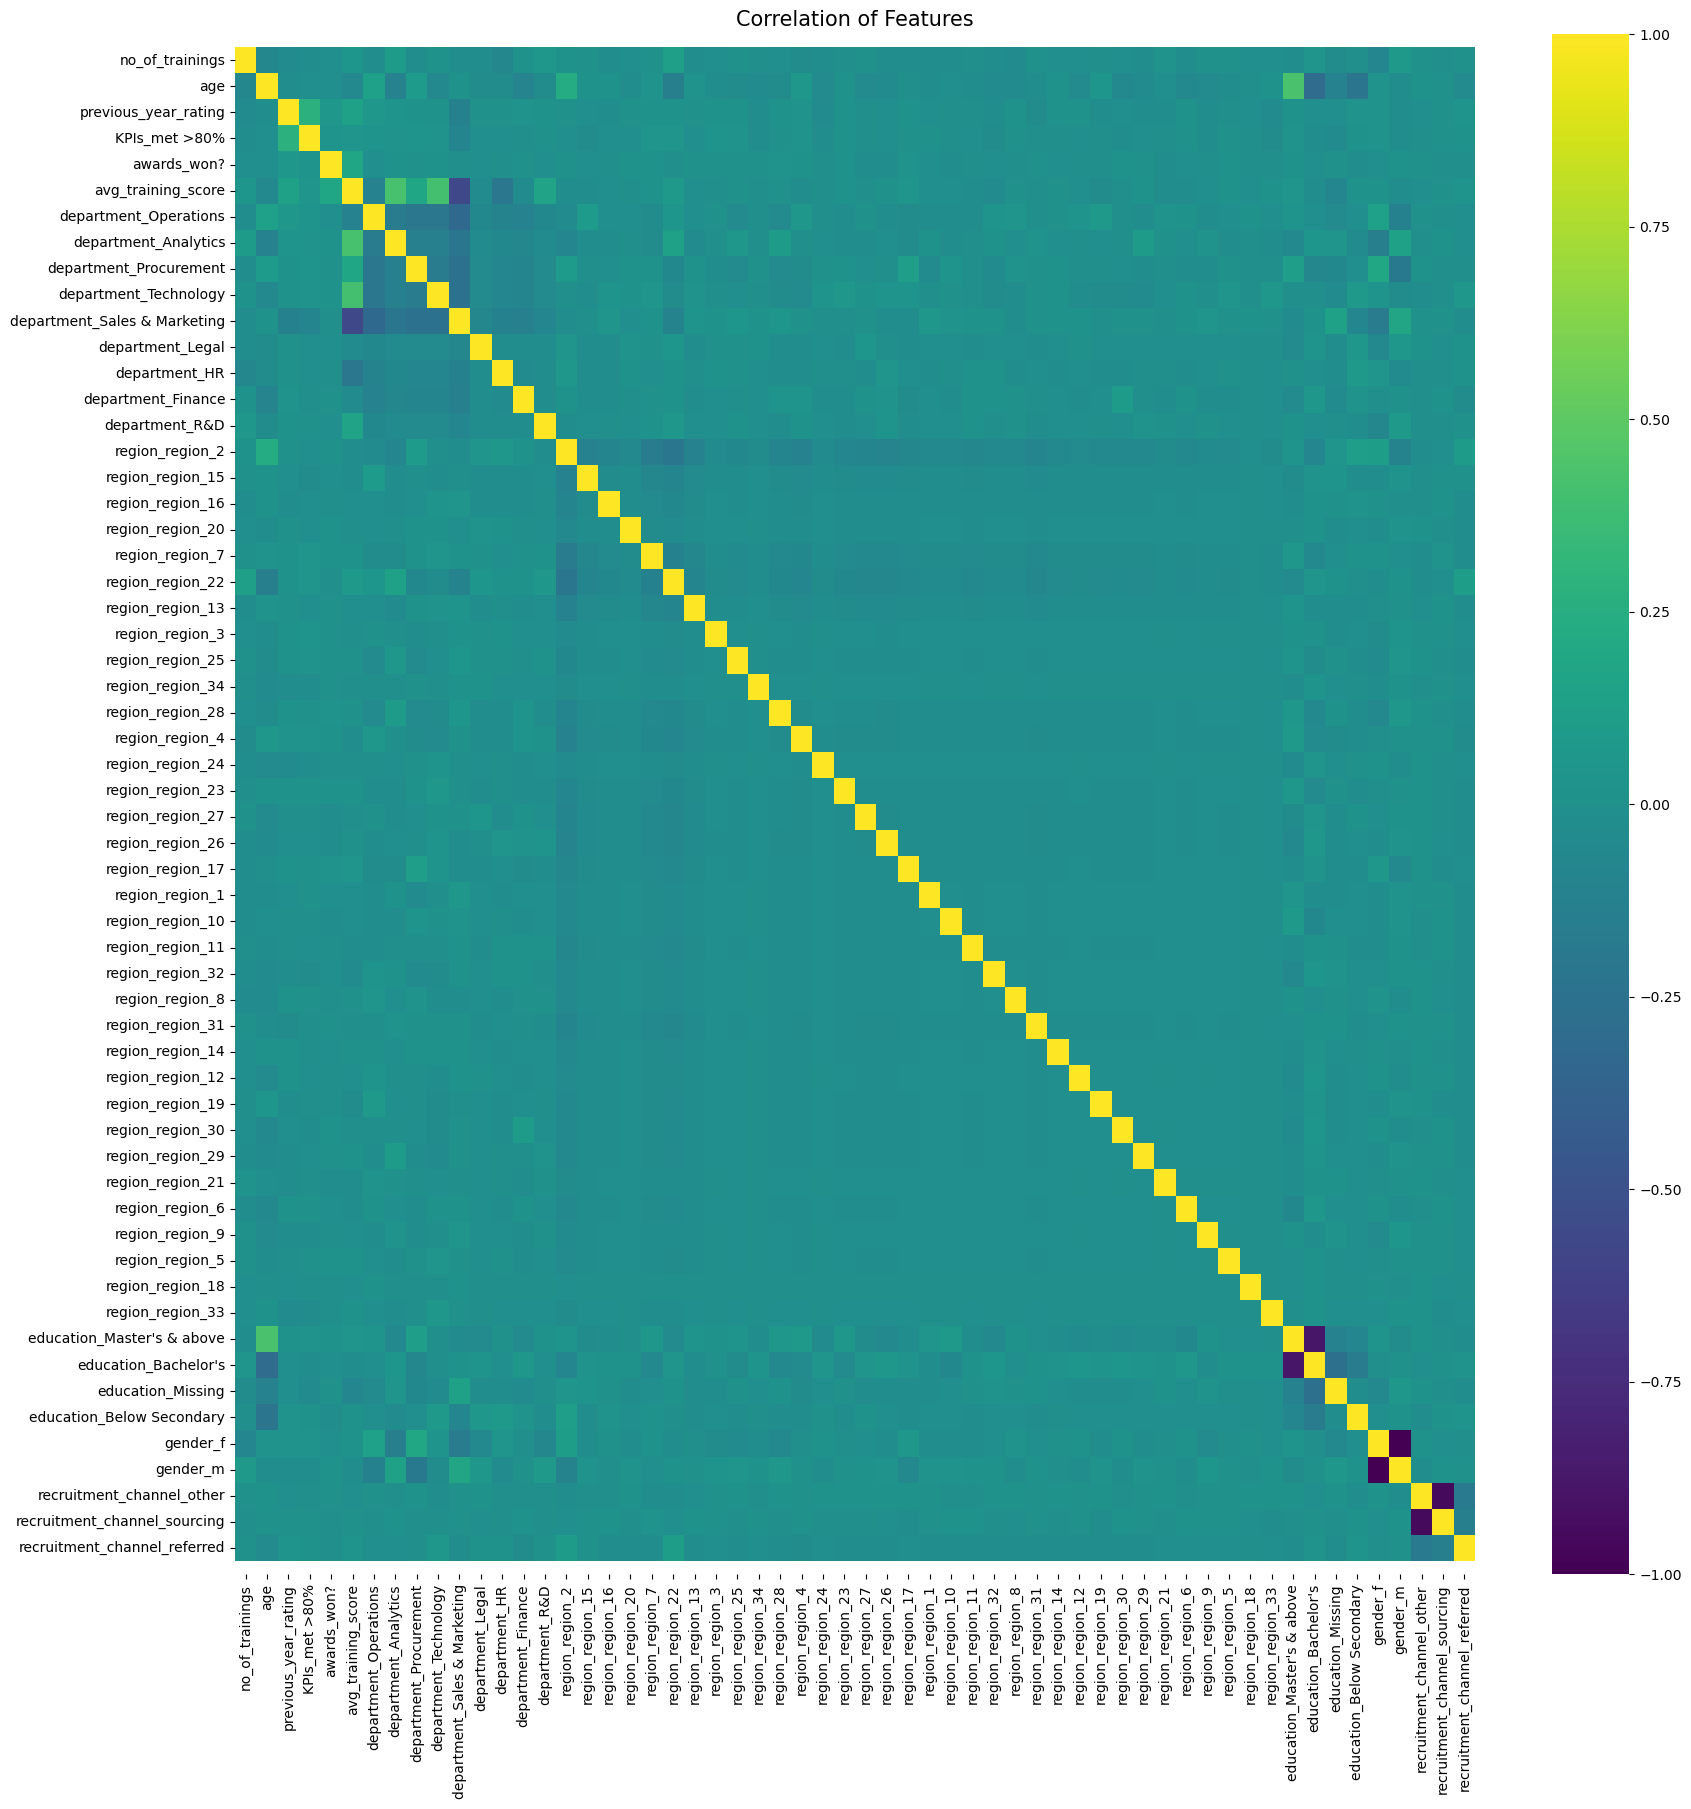

In [82]:
# Build a heatmap to visualize correlation
colormap = plt.cm.viridis
plt.figure(figsize=(20,20))
plt.title('Correlation of Features', size=15)
ax = sns.heatmap(X_train_final.corr(), cmap=colormap, annot=False)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

#### Testing data on model (Logistic Regression)

In [83]:
# Model
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=300)
logreg.fit(X_train_final, hr_y_train)

LogisticRegression(max_iter=300)

In [84]:
y_pred = logreg.predict(X_test_final)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test_final, hr_y_test)))

Accuracy of logistic regression classifier on test set: 0.78


In [85]:
from sklearn.metrics import classification_report
print(classification_report(hr_y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.73      0.77      1417
           1       0.75      0.82      0.78      1384

    accuracy                           0.78      2801
   macro avg       0.78      0.78      0.78      2801
weighted avg       0.78      0.78      0.78      2801



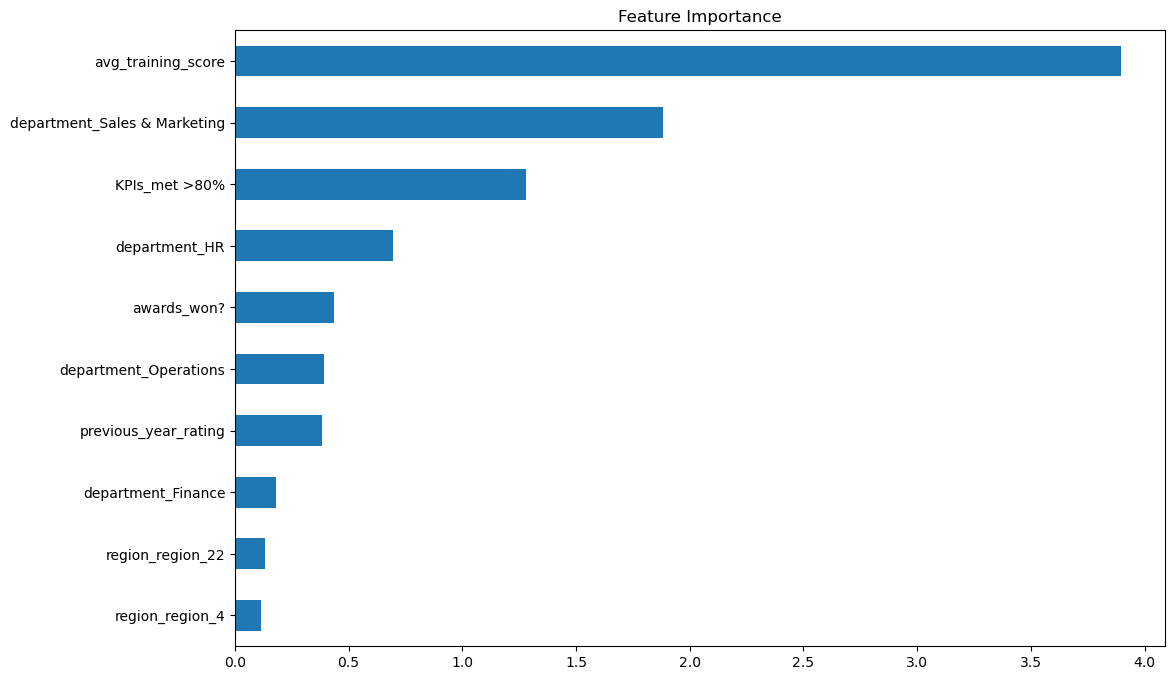

In [86]:
# Showing Features Importance (Top 10)
importance = logreg.coef_[0]
index=X_test_final.columns

# Feature Importance as a Plot
feature_importance = pd.Series(importance, index = index)
feature_importance.nlargest(10).sort_values(ascending = True).plot(kind='barh',title = 'Feature Importance',figsize=(12,8)) # Top 10
plt.show()

In [87]:
# Feature Importance as Dataframe
f_imp_df = feature_importance.to_frame(name='Feature Importance')
f_imp_df.head(10).sort_values(by='Feature Importance', ascending = False)

Feature Importance
avg_training_score                3.895145
KPIs_met >80%                     1.280552
awards_won?                       0.435652
department_Operations             0.393379
previous_year_rating              0.383350
no_of_trainings                  -0.046036
age                              -0.161155
department_Procurement           -0.577594
department_Technology            -1.240142
department_Analytics             -1.492857

In [88]:
# All Feature Importance
f_imp_df

Feature Importance
no_of_trainings                        -0.046036
age                                    -0.161155
previous_year_rating                    0.383350
KPIs_met >80%                           1.280552
awards_won?                             0.435652
avg_training_score                      3.895145
department_Operations                   0.393379
department_Analytics                   -1.492857
department_Procurement                 -0.577594
department_Technology                  -1.240142
department_Sales & Marketing            1.882666
department_Legal                        0.059969
department_HR                           0.693612
department_Finance                      0.181122
department_R&D                         -0.700569
region_region_2                         0.010200
region_region_15                       -0.010115
region_region_16                       -0.064862
region_region_20                       -0.047225
region_region_7                         0.069249
region_region_22                        0.131226
region_region_13                       -0.031551
region_region_3                        -0.048780
region_region_25                        0.045689
region_region_34                       -0.077373
region_region_28                        0.039557
region_region_4                         0.115319
region_region_24                       -0.075094
region_region_23                        0.045482
region_region_27                       -0.028647
region_region_26                       -0.074385
region_region_17                        0.047030
region_region_1                         0.014753
region_region_10                       -0.011294
region_region_11                       -0.044660
region_region_32                       -0.014206
region_region_8                        -0.025824
region_region_31                       -0.072225
region_region_14                       -0.005937
region_region_12                       -0.081556
region_region_19                       -0.018368
region_region_30                        0.015692
region_region_29                       -0.037649
region_region_21                       -0.064629
region_region_6                        -0.106376
region_region_9                        -0.095531
region_region_5                        -0.019594
region_region_18                        0.017779
region_region_33                       -0.006037
education_Master's & above              0.073324
education_Bachelor's                   -0.007153
education_Missing                      -0.114630
education_Below Secondary              -0.069778
gender_f                                0.014535
gender_m                               -0.014535
recruitment_channel_other               0.011503
recruitment_channel_sourcing           -0.012402
recruitment_channel_referred            0.002518

In [89]:
import statsmodels.api as sm
y = list(hr_y_train)
lg2 = sm.Logit(y, X_train_final).fit(maxiter = 300)


         Current function value: 0.424022
         Iterations: 300


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [90]:
# Print out the Model Summary
lg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 6535
Model:                          Logit   Df Residuals:                     6482
Method:                           MLE   Df Model:                           52
Date:                Sat, 17 Dec 2022   Pseudo R-squ.:                  0.3883
Time:                        23:00:19   Log-Likelihood:                -2771.0
converged:                      False   LL-Null:                       -4529.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
no_of_trainings                 -0.0492      0.035     -1.417      0.156      -0.117       0.019
age                             -0.1703      0.042     -4.054      0.000      -0.253      -0.088
previous_year_rating             0.4144      0.039     10.624      0.000       0.338       0.491
KPIs_met >80%                    1.3091      0.042     31.158      0.000       1.227       1.391
awards_won?                      0.3809      0.044      8.749      0.000       0.296       0.466
avg_training_score               3.7283      0.119     31.434      0.000       3.496       3.961
department_Operations            0.3761        nan        nan        nan         nan         nan
department_Analytics            -1.4216        nan        nan        nan         nan         nan
department_Procurement          -0.5520        nan        nan        nan         nan         nan
department_Technology           -1.1734        nan        nan        nan         nan         nan
department_Sales & Marketing     1.7916        nan        nan        nan         nan         nan
department_Legal                 0.0498        nan        nan        nan         nan         nan
department_HR                    0.6567        nan        nan        nan         nan         nan
department_Finance               0.1739        nan        nan        nan         nan         nan
department_R&D                  -0.6729        nan        nan        nan         nan         nan
region_region_2                  0.0160        nan        nan        nan         nan         nan
region_region_15                -0.0085        nan        nan        nan         nan         nan
region_region_16                -0.0664        nan        nan        nan         nan         nan
region_region_20                -0.0516        nan        nan        nan         nan         nan
region_region_7                  0.0735        nan        nan        nan         nan         nan
region_region_22                 0.1356        nan        nan        nan         nan         nan
region_region_13                -0.0325        nan        nan        nan         nan         nan
region_region_3                 -0.0501        nan        nan        nan         nan         nan
region_region_25                 0.0465        nan        nan        nan         nan         nan
region_region_34                -0.0821        nan        nan        nan         nan         nan
region_region_28                 0.0400        nan        nan        nan         nan         nan
region_region_4                  0.1141        nan        nan        nan         nan         nan
region_region_24                -0.0787        nan        nan        nan         nan         nan
region_region_23                 0.0468        nan        nan        nan         nan         nan
region_region_27                -0.0314        nan        nan        nan         nan         nan
region_region_26                -0.0772 

### 1.4 Export the data

In [91]:
# Combine Target and Predictors
X=pd.concat([X_train_final,X_test_final],axis=0)
Y=pd.concat([hr_y_train,hr_y_test],axis=0)
# Reset index to join
X = X.reset_index()
Y = Y.reset_index()
# Combine Train and Test sets
hr_data=pd.concat([X,Y],axis=1)
# Write to new excel file
hr_data.to_csv('hr_data_new.csv', encoding='utf-8', index=False)

In [92]:
hr_data.head()

index  no_of_trainings       age  previous_year_rating  KPIs_met >80%  \
0      0        -0.451441  1.399407              0.365476       0.992530   
1      1        -0.451441  2.073279             -0.381427      -1.007526   
2      2        -0.451441 -0.296483             -1.319632      -1.007526   
3      3        -0.451441  1.399407             -0.381427      -1.007526   
4      4         2.018952  1.650774              0.996208       0.992530   

   awards_won?  avg_training_score  department_Operations  \
0    -0.268355           -0.361384               1.928318   
1    -0.268355            1.202524              -0.518587   
2    -0.268355           -0.584320               1.928318   
3    -0.268355           -0.361384               1.928318   
4    -0.268355            0.199411              -0.518587   

   department_Analytics  department_Procurement  ...  education_Bachelor's  \
0             -0.345806               -0.404780  ...             -1.382358   
1              2.891793               -0.404780  ...              0.723402   
2             -0.345806               -0.404780  ...              0.723402   
3             -0.345806               -0.404780  ...              0.723402   
4             -0.345806                2.470478  ...             -1.382358   

   education_Missing  education_Below Secondary  gender_f  gender_m  \
0          -0.192282                  -0.126545  1.522808 -1.522808   
1          -0.192282                  -0.126545 -0.656682  0.656682   
2          -0.192282                  -0.126545 -0.656682  0.656682   
3          -0.192282                  -0.126545  1.522808 -1.522808   
4          -0.192282                  -0.126545  1.522808 -1.522808   

   recruitment_channel_other  recruitment_channel_sourcing  \
0                   0.911054                     -0.862590   
1                   0.911054                     -0.862590   
2                   0.911054                     -0.862590   
3                  -1.097630                      1.159299   
4                   0.911054                     -0.862590   

   recruitment_channel_referred  index  is_promoted  
0                     -0.166365   8032            0  
1                     -0.166365  32675            0  
2                     -0.166365  16546            0  
3                     -0.166365  43038            0  
4                     -0.166365  14612            0  

[5 rows x 61 columns]

## 2. Airbnb

### 2.1 Load and Explore the data

#### Load & Overview

In [93]:
# Airbnb
bnb_data = pd.read_csv('data/listings.csv')

In [94]:
# Explore Statistical & Relationships
bnb_data.info()
bnb_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7907 entries, 0 to 7906
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              7907 non-null   int64  
 1   name                            7905 non-null   object 
 2   host_id                         7907 non-null   int64  
 3   host_name                       7907 non-null   object 
 4   neighbourhood_group             7907 non-null   object 
 5   neighbourhood                   7907 non-null   object 
 6   latitude                        7907 non-null   float64
 7   longitude                       7907 non-null   float64
 8   room_type                       7907 non-null   object 
 9   price                           7907 non-null   int64  
 10  minimum_nights                  7907 non-null   int64  
 11  number_of_reviews               7907 non-null   int64  
 12  last_review                     51

id       host_id     latitude    longitude         price  \
count  7.907000e+03  7.907000e+03  7907.000000  7907.000000   7907.000000   
mean   2.338862e+07  9.114481e+07     1.314192   103.848787    169.332996   
std    1.016416e+07  8.190910e+07     0.030577     0.043675    340.187599   
min    4.909100e+04  2.366600e+04     1.243870   103.646560      0.000000   
25%    1.582180e+07  2.305808e+07     1.295795   103.835825     65.000000   
50%    2.470627e+07  6.344891e+07     1.311030   103.849410    124.000000   
75%    3.234850e+07  1.553811e+08     1.322110   103.872535    199.000000   
max    3.811276e+07  2.885676e+08     1.454590   103.973420  10000.000000   

       minimum_nights  number_of_reviews  reviews_per_month  \
count     7907.000000        7907.000000        5149.000000   
mean        17.510054          12.807386           1.043669   
std         42.094616          29.707746           1.285851   
min          1.000000           0.000000           0.010000   
25%          1.000000           0.000000           0.180000   
50%          3.000000           2.000000           0.550000   
75%         10.000000          10.000000           1.370000   
max       1000.000000         323.000000          13.000000   

       calculated_host_listings_count  availability_365  
count                     7907.000000       7907.000000  
mean                        40.607689        208.726318  
std                         65.135253        146.120034  
min                          1.000000          0.000000  
25%                          2.000000         54.000000  
50%                          9.000000        260.000000  
75%                         48.000000        355.000000  
max                        274.000000        365.000000

#### Looking at unique values in categorical features

In [95]:
# Categorical Features
cat_cols = [c for c in bnb_data.columns if bnb_data[c].dtypes=='O']
bnb_data[cat_cols]

name  host_name  \
0                     COZICOMFORT LONG TERM STAY ROOM 2  Francesca   
1                       Pleasant Room along Bukit Timah    Sujatha   
2                                           COZICOMFORT  Francesca   
3                   Ensuite Room (Room 1 & 2) near EXPO    Belinda   
4                       B&B  Room 1 near Airport & EXPO    Belinda   
...                                                 ...        ...   
7902  Loft 2 pax near Haw Par / Pasir Panjang. Free ...      Belle   
7903                         3bedroom luxury at Orchard       Neha   
7904    [ Farrer Park ] New City Fringe CBD Mins to MRT      Mindy   
7905          Cheap Master Room in Central of Singapore      Huang   
7906  Amazing room with private bathroom walk to Orc...    Terence   

     neighbourhood_group neighbourhood        room_type last_review  
0           North Region     Woodlands     Private room  21/10/2013  
1         Central Region   Bukit Timah     Private room  26/12/2014  
2           North Region     Woodlands     Private room   1/10/2015  
3            East Region      Tampines     Private room   11/8/2019  
4            East Region      Tampines     Private room   28/7/2019  
...                  ...           ...              ...         ...  
7902      Central Region    Queenstown  Entire home/apt         NaN  
7903      Central Region       Tanglin  Entire home/apt         NaN  
7904      Central Region       Kallang     Private room         NaN  
7905      Central Region  River Valley     Private room         NaN  
7906      Central Region  River Valley     Private room         NaN  

[7907 rows x 6 columns]

In [96]:
# Name Unique
bnb_data.name.value_counts()

Luxury hostel with in-cabin locker - Single mixed     13
Inviting & Cozy 1BR APT 3 mins from Tg Pagar MRT       9
Studio Apartment - Oakwood Premier                     9
Tasteful & Cozy 1 BR near SGH/Tiong Bahru              8
Superhost 1BR APT in the heart of Tg Pagar             8
                                                      ..
Tanjong Pagar Pristine Studio Apartment                1
lavLoftbed *RmT, no-sharing, wifi, mrt                 1
Newly furnished spacious room                          1
Traditional Shophouse with modern and sleek design     1
Amazing room with private bathroom walk to Orchard     1
Name: name, Length: 7454, dtype: int64

In [97]:
# Host Name Unique
bnb_data.host_name.value_counts()

Jay         290
Alvin       249
Richards    157
Aaron       145
Rain        115
           ... 
Nassiba       1
Dianna        1
Geo           1
Ziad          1
Bo            1
Name: host_name, Length: 1833, dtype: int64

In [98]:
# Neighbourhood Group Unique
bnb_data.neighbourhood_group.value_counts()

Central Region       6309
West Region           540
East Region           508
North-East Region     346
North Region          204
Name: neighbourhood_group, dtype: int64

In [99]:
# Neighbourhood Unique
bnb_data.neighbourhood.value_counts()

Kallang                    1043
Geylang                     994
Novena                      537
Rochor                      536
Outram                      477
Bukit Merah                 470
Downtown Core               428
Bedok                       373
River Valley                362
Queenstown                  266
Tanglin                     210
Singapore River             175
Marine Parade               171
Jurong West                 153
Orchard                     136
Newton                      134
Bukit Timah                 131
Jurong East                 118
Hougang                     109
Clementi                    102
Toa Payoh                   101
Pasir Ris                    71
Serangoon                    69
Sengkang                     67
Woodlands                    67
Bukit Batok                  65
Tampines                     64
Museum                       63
Choa Chu Kang                63
Ang Mo Kio                   58
Bishan                       57
Yishun  

In [100]:
# Room Type Unique
bnb_data.room_type.value_counts()

Entire home/apt    4132
Private room       3381
Shared room         394
Name: room_type, dtype: int64

In [101]:
# Last Review Unique
bnb_data.last_review.value_counts()

12/8/2019    152
11/8/2019    128
13/8/2019    110
10/8/2019     87
8/8/2019      78
            ... 
3/12/2016      1
18/1/2016      1
27/7/2016      1
19/8/2017      1
22/3/2019      1
Name: last_review, Length: 1001, dtype: int64

#### Look at statistical distribution of numerical features (boxplot & histogram)

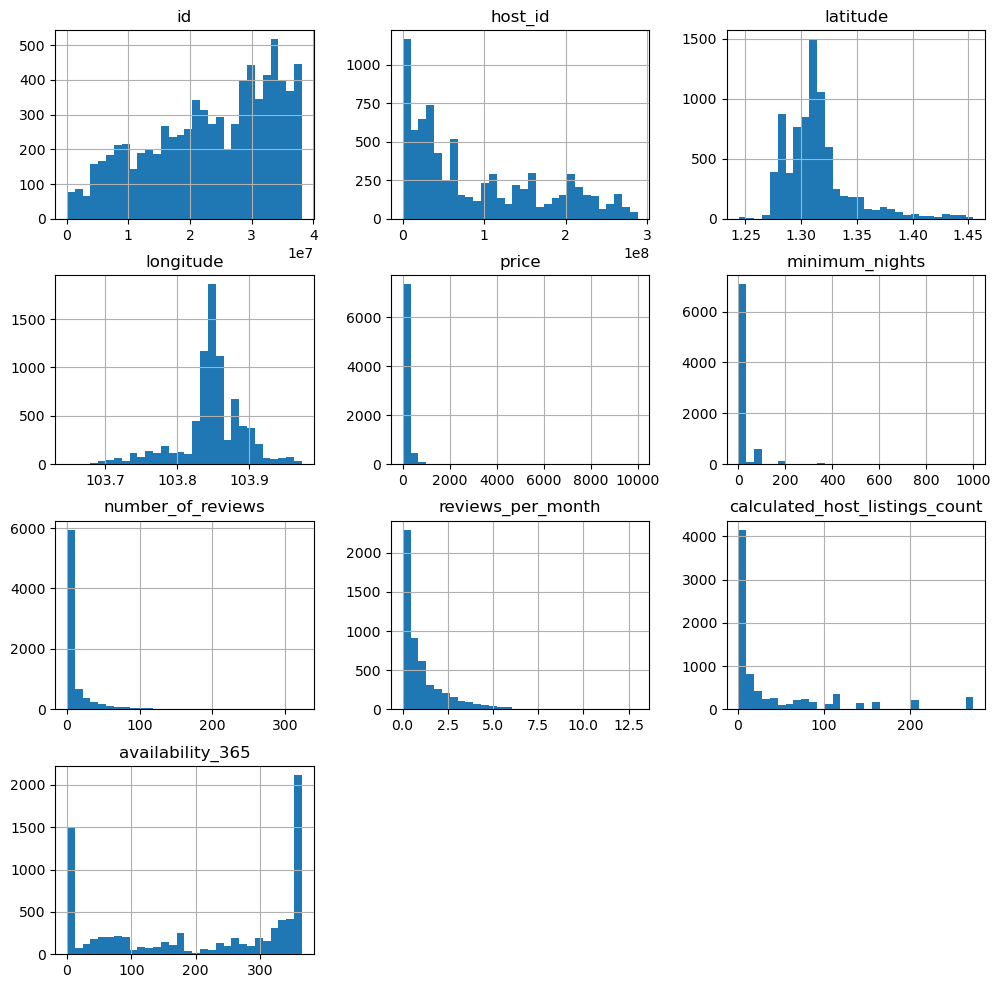

In [102]:
bnb_data.hist(bins=30, figsize=(12,12))
plt.show()

#### Exploratory Data Analysis

#### Which room types are more expensive?

In [103]:
# Which room types are more expensive?
# Dataframe for "Which room types are more expensive?"
df1 = bnb_data[['room_type','price']].copy()
df1 = df1.groupby(['room_type']).mean()
df1.head()


price
room_type                  
Entire home/apt  226.998306
Private room     110.938480
Shared room       65.675127

<AxesSubplot:xlabel='room_type'>

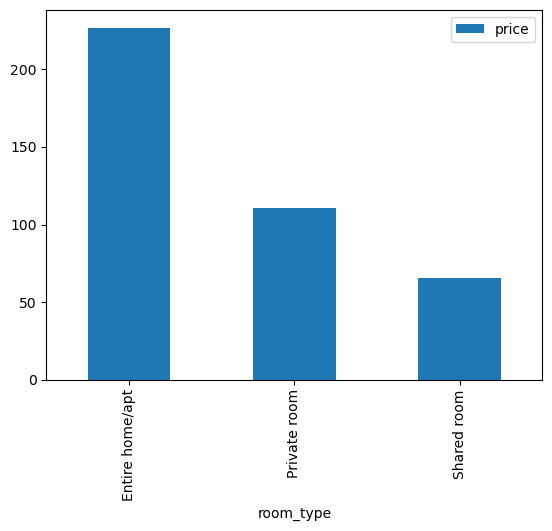

In [104]:
df1.plot.bar()

In [105]:
# Conclusion: Based on the bar chart, it is observed that “Entire home/apt” is the most expensive room type on average.

#### What is the distribution of prices across neighbourhood regions?

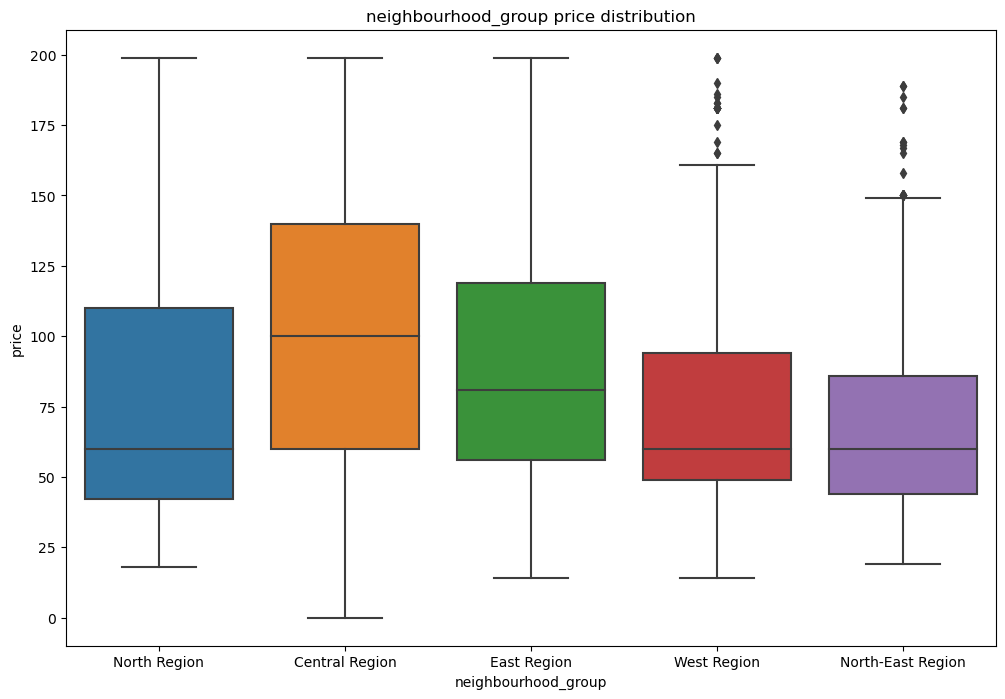

In [106]:
# Distribution of prices across neighbourhood regions.
# Set bounds to 75th percentile (199)
nprice = bnb_data[bnb_data.price<200]
plt.figure(figsize=(12,8))
sns.boxplot(y="price",x ='neighbourhood_group' ,data = nprice)
plt.title("neighbourhood_group price distribution")
plt.show()

In [107]:
# Conclusion: Central Region is shown to have the highest price distribution among the neighbourhood groups.
# This will be helpful for building a specialized model for predicting price in the central region.

#### What are the popular Room Types for airbnbs?

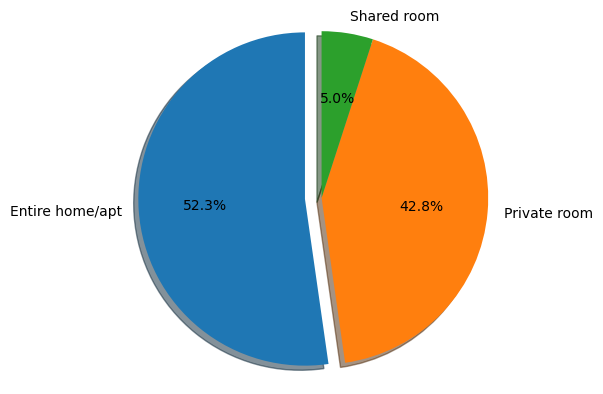

In [108]:
# Popular Room Types for Airbnb
df2 = bnb_data.groupby(['room_type']).size()/bnb_data['room_type'].count()*100
labels = df2.index
value = df2.values

explode = (0.1, 0, 0)
fig1, ax1 = plt.subplots()
ax1.pie(value, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

In [109]:
# Conclusion: Entire home/apt has the highest share of listings on airbnb and is the preferred room type. 
# Conversely, Shared room is the leased prefered, with the lowest share among the room types.

#### Reviews per Month vs Price

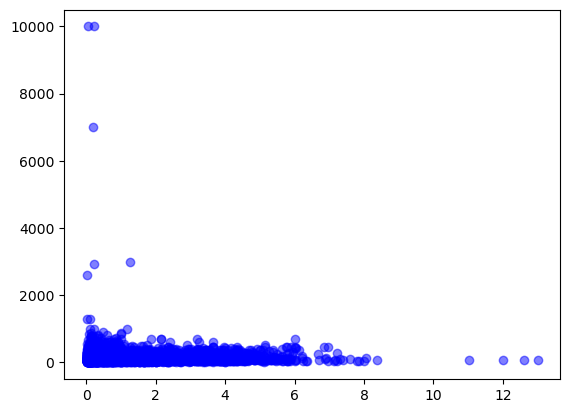

In [110]:
# Reviews per Month vs Price
df4 = bnb_data[['reviews_per_month','price']].copy()
#df4 = df4.dropna()
x = df4.reviews_per_month
y = df4.price
plt.scatter(x, y, c='b', alpha=0.5)
plt.show()


#### Minimum Nights vs Price

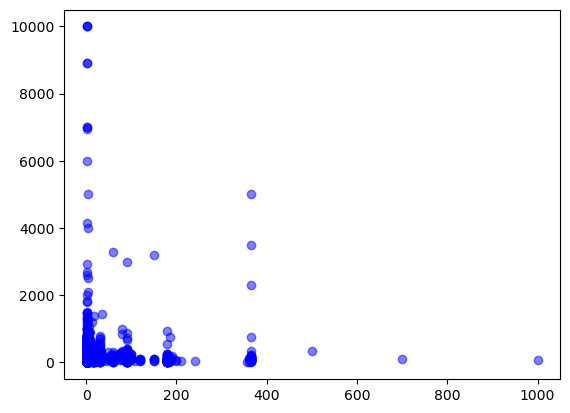

In [111]:
# Minimum Nights vs Price
df5 = bnb_data[['minimum_nights','price']].copy()
#df5 = df5.dropna()
x = df5.minimum_nights
y = df5.price
plt.scatter(x, y, c='b', alpha=0.5)
plt.show()

In [112]:
# Conclusion both scatter: For reviews per month against price, there seems to be a slight positive correlation, 
# and for minimum nights and price, there also appears to be a slight positive correlation ignoring the outliers.

#### Airbnb locations ('latitude' & 'longitude') by region

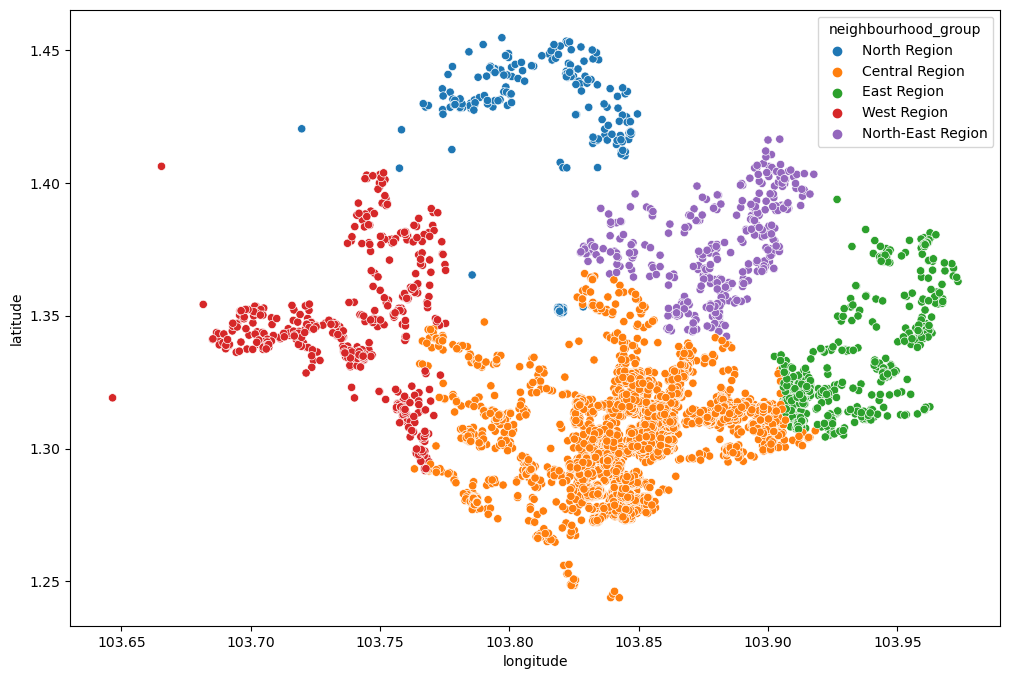

In [113]:
# Airbnb locations by region
df6 = bnb_data[['latitude','longitude', 'neighbourhood_group']].copy()
plt.figure(figsize=(12,8))
x = df6.longitude
y = df6.latitude
sns.scatterplot(x=x,y=y, hue=df6.neighbourhood_group)
plt.show()

In [114]:
# Conclusion: From the visual, we can see that many of the Airbnb listings are concentrated in the central region. 
# This is another indicator that it is more effective to build a model to predict prices in the central region only.

#### Correlation of Features (Before Transformation)

In [115]:
# Correlation before Transformation
# Inspect Correlation of features
bnb_data.corr()

id   host_id  latitude  longitude  \
id                              1.000000  0.541770 -0.112042  -0.004701   
host_id                         0.541770  1.000000 -0.041237  -0.016341   
latitude                       -0.112042 -0.041237  1.000000  -0.034970   
longitude                      -0.004701 -0.016341 -0.034970   1.000000   
price                           0.049324  0.038802 -0.073990  -0.030436   
minimum_nights                 -0.083037 -0.089862  0.084924  -0.029208   
number_of_reviews              -0.341513 -0.175573 -0.015022   0.102109   
reviews_per_month               0.199958  0.169950 -0.029580   0.117578   
calculated_host_listings_count  0.245014 -0.063522 -0.149961   0.049416   
availability_365                0.113259  0.041840 -0.068740  -0.035727   

                                   price  minimum_nights  number_of_reviews  \
id                              0.049324       -0.083037          -0.341513   
host_id                         0.038802       -0.089862          -0.175573   
latitude                       -0.073990        0.084924          -0.015022   
longitude                      -0.030436       -0.029208           0.102109   
price                           1.000000       -0.012214          -0.042013   
minimum_nights                 -0.012214        1.000000          -0.076475   
number_of_reviews              -0.042013       -0.076475           1.000000   
reviews_per_month               0.000920       -0.139469           0.627965   
calculated_host_listings_count  0.016555       -0.013964          -0.149681   
availability_365                0.017451        0.150356          -0.066658   

                                reviews_per_month  \
id                                       0.199958   
host_id                                  0.169950   
latitude                                -0.029580   
longitude                                0.117578   
price                                    0.000920   
minimum_nights                          -0.139469   
number_of_reviews                        0.627965   
reviews_per_month                        1.000000   
calculated_host_listings_count          -0.195962   
availability_365                        -0.108243   

                                calculated_host_listings_count  \
id                                                    0.245014   
host_id                                              -0.063522   
latitude                                             -0.149961   
longitude                                             0.049416   
price                                                 0.016555   
minimum_nights                                       -0.013964   
number_of_reviews                                    -0.149681   
reviews_per_month                                    -0.195962   
calculated_host_listings_count                        1.000000   
availability_365                                      0.246230   

                                availability_365  
id                                      0.113259  
host_id                                 0.041840  
latitude                               -0.068740  
longitude                              -0.035727  
price                                   0.017451  
minimum_nights                          0.150356  
number_of_reviews                      -0.066658  
reviews_per_month                      -0.108243  
calculated_host_listings_count          0.246230  
availability_365                        1.000000

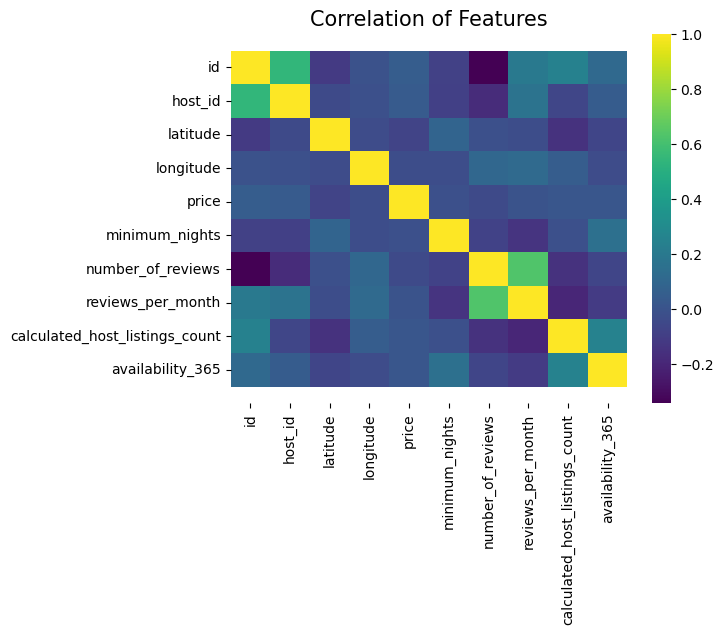

In [116]:
# Build a heatmap to visualize correlation
colormap = plt.cm.viridis
#plt.figure(figsize=(20,20))
plt.title('Correlation of Features', size=15)
ax = sns.heatmap(bnb_data.corr(), cmap=colormap, annot=False)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

#### Value Based Problem Statement

Predict the prices for airbnbs in the central region based on its characteristics.

### 2.2 Cleanse and Transform the data

#### Filter by Central Region

In [117]:
# Central Region (for problem statement)
bnb_data = bnb_data.loc[bnb_data['neighbourhood_group'] == 'Central Region']
bnb_data.head()

id                                               name  host_id  \
1    50646                    Pleasant Room along Bukit Timah   227796   
10  275343  Conveniently located City Room!( (Phone number...  1439258   
11  275344              15 mins to Outram MRT Single Room (B)  1439258   
13  294281                     5 mins walk from Newton subway  1521514   
14  324945                 20 Mins to Sentosa @ Hilltop ! (8)  1439258   

        host_name neighbourhood_group neighbourhood  latitude  longitude  \
1         Sujatha      Central Region   Bukit Timah   1.33235  103.78521   
10  K2 Guesthouse      Central Region   Bukit Merah   1.28875  103.80814   
11  K2 Guesthouse      Central Region   Bukit Merah   1.28837  103.81099   
13      Elizabeth      Central Region        Newton   1.31125  103.83816   
14  K2 Guesthouse      Central Region   Bukit Merah   1.28976  103.80896   

       room_type  price  minimum_nights  number_of_reviews last_review  \
1   Private room     81              90                 18  26/12/2014   
10  Private room     44              15                 18   21/4/2019   
11  Private room     40              30                 10   13/9/2018   
13  Private room     65               2                125   22/8/2019   
14  Private room     44              30                 13    2/2/2019   

    reviews_per_month  calculated_host_listings_count  availability_365  
1                0.28                               1               365  
10               0.23                              32               331  
11               0.11                              32               276  
13               1.35                               6               336  
14               0.15                              32               340

#### Handle Missing Values

In [118]:
# Find Missing
# Missing Values in Numerical Columns
num_cols = [c for c in bnb_data.columns if bnb_data[c].dtypes !='O']
bnb_data[num_cols].isnull().mean().sort_values()

id                                0.000000
host_id                           0.000000
latitude                          0.000000
longitude                         0.000000
price                             0.000000
minimum_nights                    0.000000
number_of_reviews                 0.000000
calculated_host_listings_count    0.000000
availability_365                  0.000000
reviews_per_month                 0.343161
dtype: float64

In [119]:
# Missing Values in Categorical Columns
cat_cols = [c for c in bnb_data.columns if bnb_data[c].dtypes=='O']
bnb_data[cat_cols].isnull().mean().sort_values()

host_name              0.000000
neighbourhood_group    0.000000
neighbourhood          0.000000
room_type              0.000000
name                   0.000317
last_review            0.343161
dtype: float64

In [120]:
# Found in Last Review and Reviews per Month
# Reviews per Month can be mean()
# Last Review & name impute with missing

In [121]:
features_num_arbitrary = ['reviews_per_month'] # average
features_cat_missing = ['last_review', 'name'] # missing

In [122]:
pipe = Pipeline(steps=[
    ('imp_num_arbitrary', mdi.ArbitraryNumberImputer(arbitrary_number=0, variables = features_num_arbitrary)),
    ('imp_cat_missing', mdi.CategoricalImputer(variables=features_cat_missing, imputation_method='missing'))
])

# fit preprocessor
pipe.fit(bnb_data)

# impute data
bnb_data_im = pipe.transform(bnb_data)

In [123]:
# Recheck missing values
# Missing Values in Numerical Columns
num_cols = [c for c in bnb_data_im.columns if bnb_data_im[c].dtypes !='O']
bnb_data_im[num_cols].isnull().mean().sort_values()

id                                0.0
host_id                           0.0
latitude                          0.0
longitude                         0.0
price                             0.0
minimum_nights                    0.0
number_of_reviews                 0.0
reviews_per_month                 0.0
calculated_host_listings_count    0.0
availability_365                  0.0
dtype: float64

In [124]:
# Missing Values in Categorical Columns
cat_cols = [c for c in bnb_data_im.columns if bnb_data_im[c].dtypes=='O']
bnb_data_im[cat_cols].isnull().mean().sort_values()

name                   0.0
host_name              0.0
neighbourhood_group    0.0
neighbourhood          0.0
room_type              0.0
last_review            0.0
dtype: float64

#### Outlier Handling

In [125]:
# Outlier Handling (keep for first model)
# define function for diagnostic 
def diagnostic_plots(df, variable):
    # dataframe and a variable are used as arguments to generate the plots

    # Figure size
    plt.figure(figsize=(16, 4))
    plt.suptitle('{}'.format(variable), fontsize=16) #set variable as title

    # Histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Sample Quantiles')

    # Box-Plot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

In [126]:
bnb_data.describe()

id       host_id     latitude    longitude         price  \
count  6.309000e+03  6.309000e+03  6309.000000  6309.000000   6309.000000   
mean   2.411995e+07  9.267363e+07     1.303630   103.850989    176.629418   
std    1.005719e+07  8.376708e+07     0.016459     0.025049    293.992420   
min    5.064600e+04  2.366600e+04     1.243870   103.763270      0.000000   
25%    1.660310e+07  2.114972e+07     1.290980   103.839270     81.000000   
50%    2.643067e+07  6.344891e+07     1.306000   103.849320    135.000000   
75%    3.277421e+07  1.598048e+08     1.314480   103.862200    208.000000   
max    3.811276e+07  2.885676e+08     1.365830   103.918220  10000.000000   

       minimum_nights  number_of_reviews  reviews_per_month  \
count     6309.000000        6309.000000        4144.000000   
mean        15.342844          13.037724           1.079105   
std         36.047130          29.313302           1.286324   
min          1.000000           0.000000           0.010000   
25%          2.000000           0.000000           0.200000   
50%          3.000000           2.000000           0.580000   
75%         10.000000          11.000000           1.472500   
max       1000.000000         307.000000          13.000000   

       calculated_host_listings_count  availability_365  
count                     6309.000000       6309.000000  
mean                        47.304169        215.435727  
std                         67.690029        143.593737  
min                          1.000000          0.000000  
25%                          3.000000         63.000000  
50%                         14.000000        269.000000  
75%                         67.000000        355.000000  
max                        274.000000        365.000000

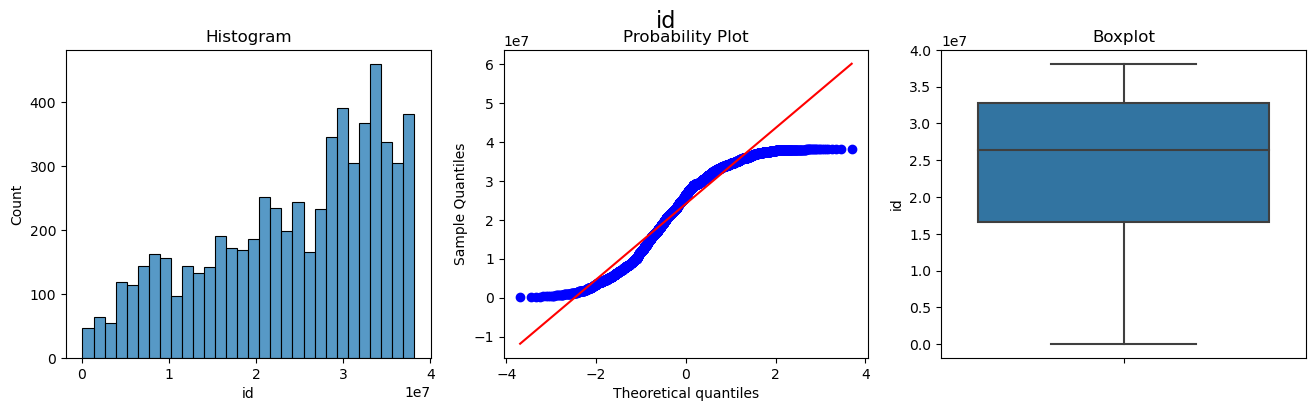

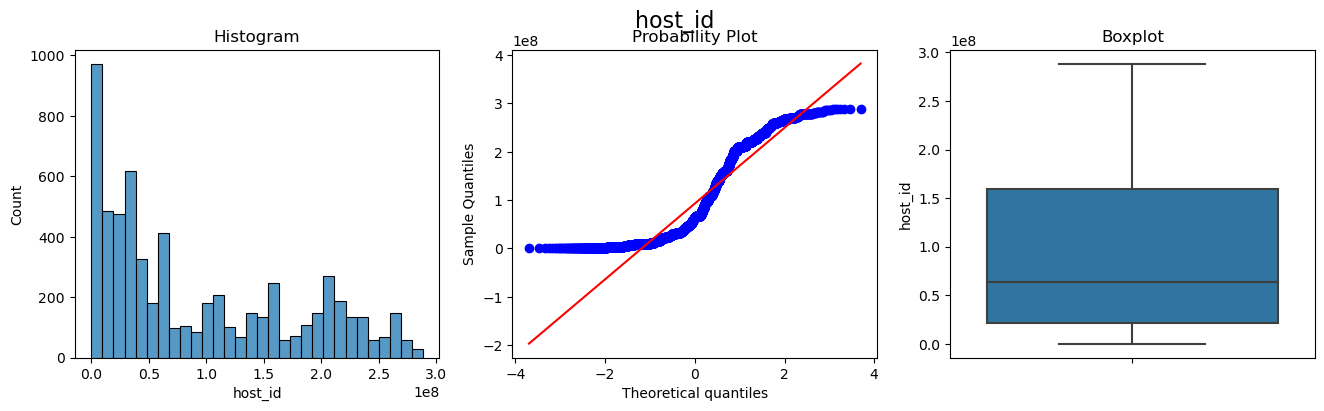

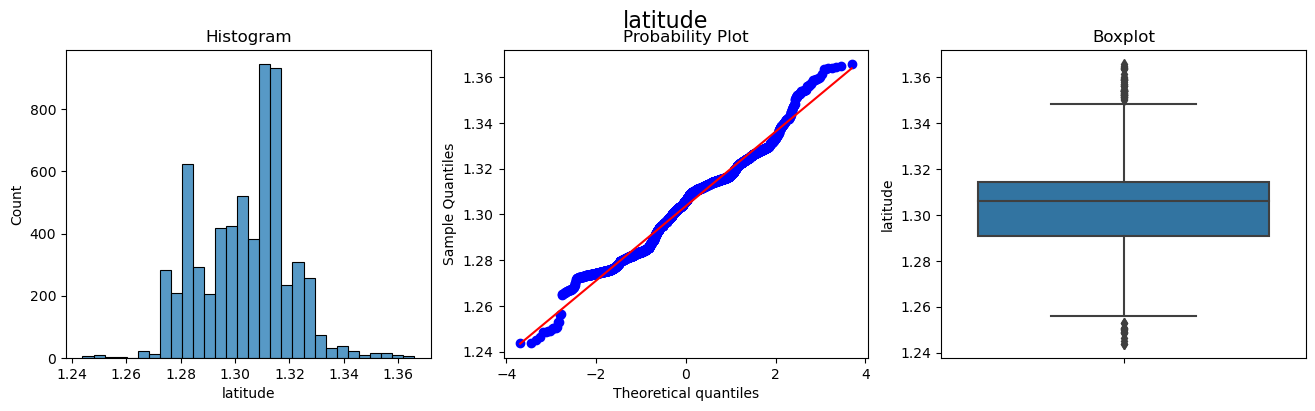

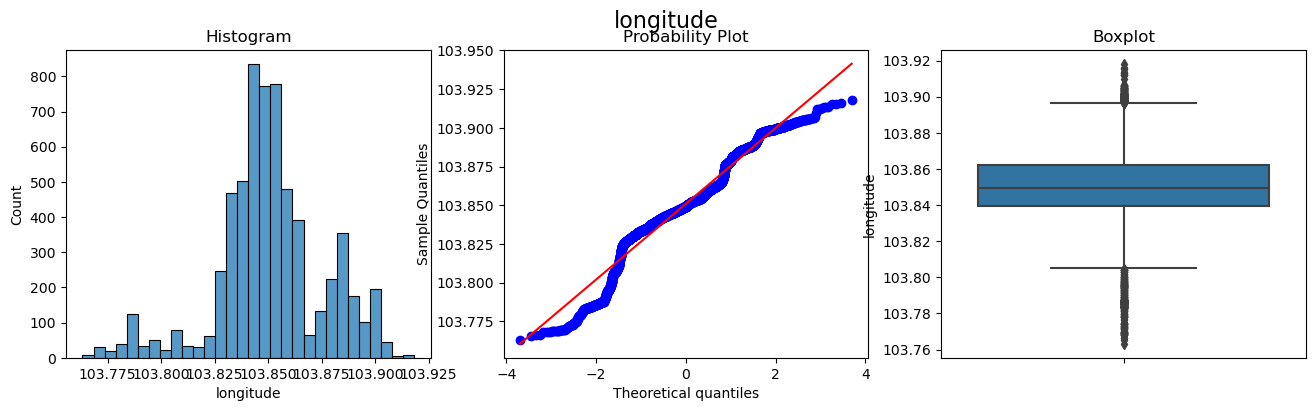

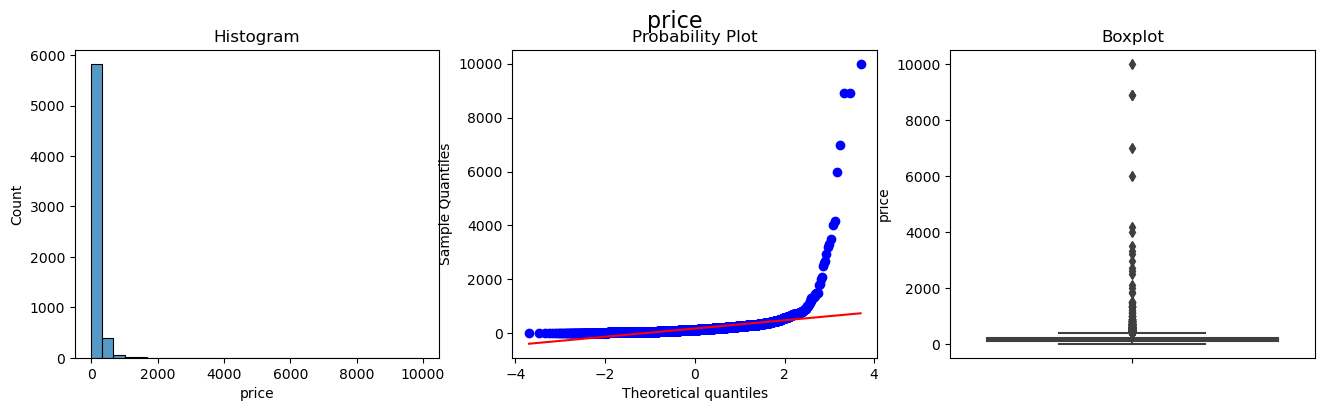

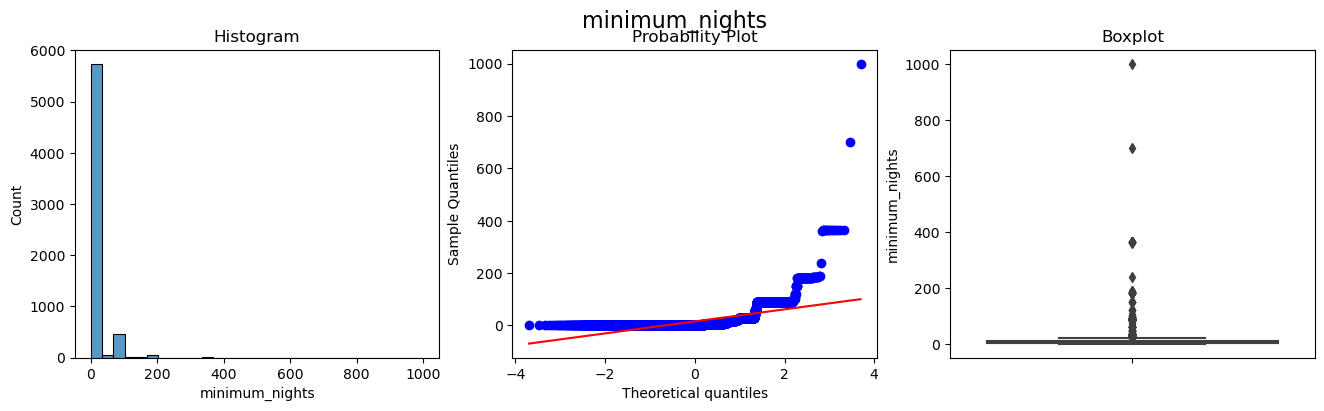

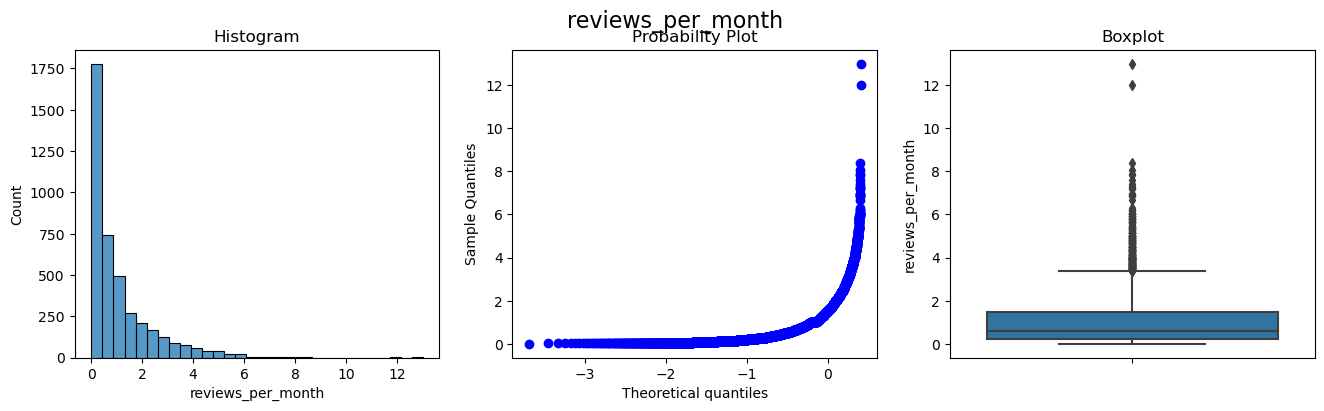

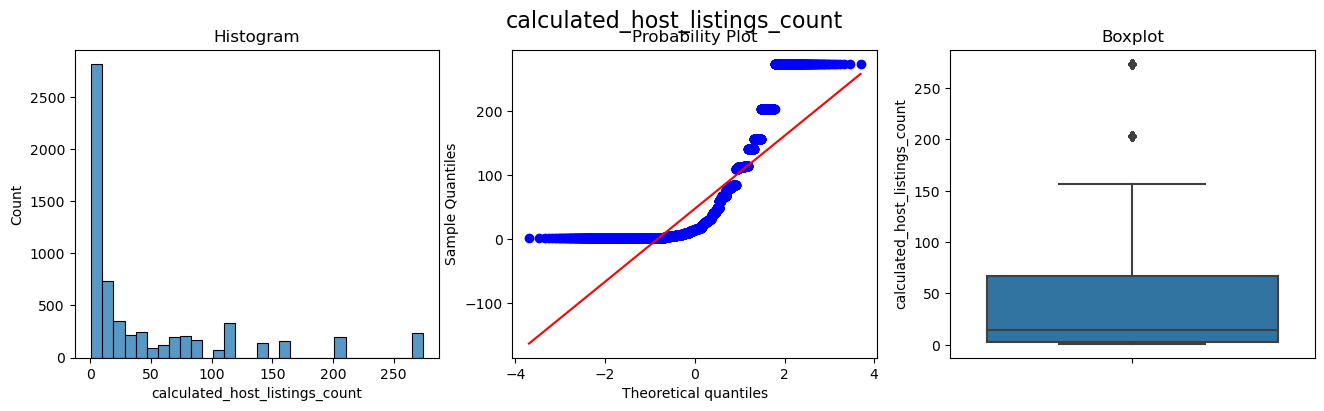

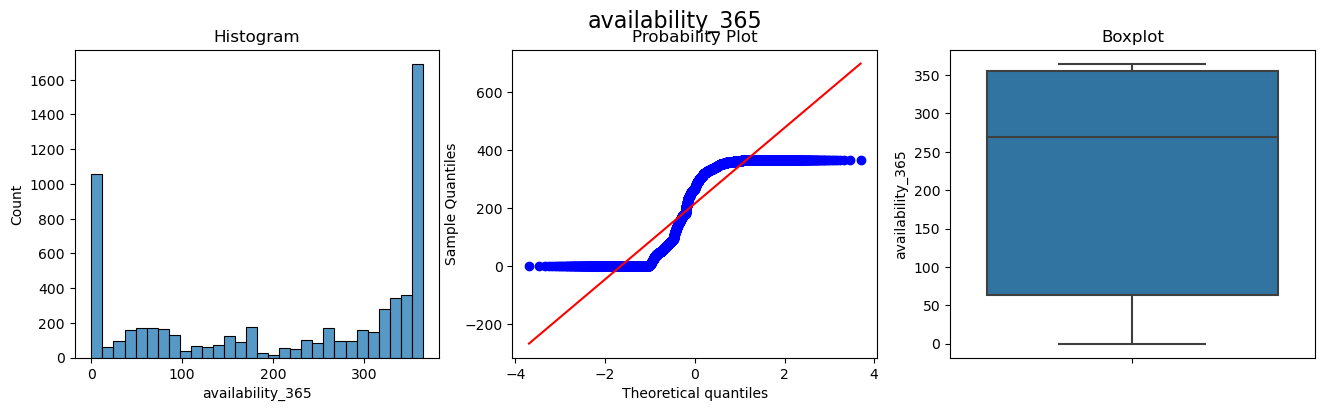

In [127]:
# diagnostic_plot (before handling)
diagnostic_plots(bnb_data, 'id') #no
diagnostic_plots(bnb_data, 'host_id') #no
diagnostic_plots(bnb_data, 'latitude') # handle
diagnostic_plots(bnb_data, 'longitude')# handle
diagnostic_plots(bnb_data, 'price') # target
diagnostic_plots(bnb_data, 'minimum_nights') # handle
diagnostic_plots(bnb_data, 'reviews_per_month')
diagnostic_plots(bnb_data, 'calculated_host_listings_count') # handle
diagnostic_plots(bnb_data, 'availability_365')

In [128]:
# Use Capping (gaussian) (affects accuracy) (poor distribution)

#windsorizer = Winsorizer(capping_method ='gaussian', 
#                        tail='both', fold = 3, 
#                         variables=['latitude', 'longitude', 'minimum_nights', 
#                                   'calculated_host_listings_count', 'reviews_per_month', "price", 'availability_365'
#                                   ])

#windsorizer.fit(bnb_data_im)
#bnb_data_o = windsorizer.transform(bnb_data_im)


In [129]:
# Use quantile capping
windsorizer = Winsorizer(capping_method ='quantiles', 
                        tail='right', fold = 0.1, 
                         variables=["price", 'minimum_nights','latitude', 'longitude', 'calculated_host_listings_count'])

windsorizer.fit(bnb_data_im)
bnb_data_o = windsorizer.transform(bnb_data_im)

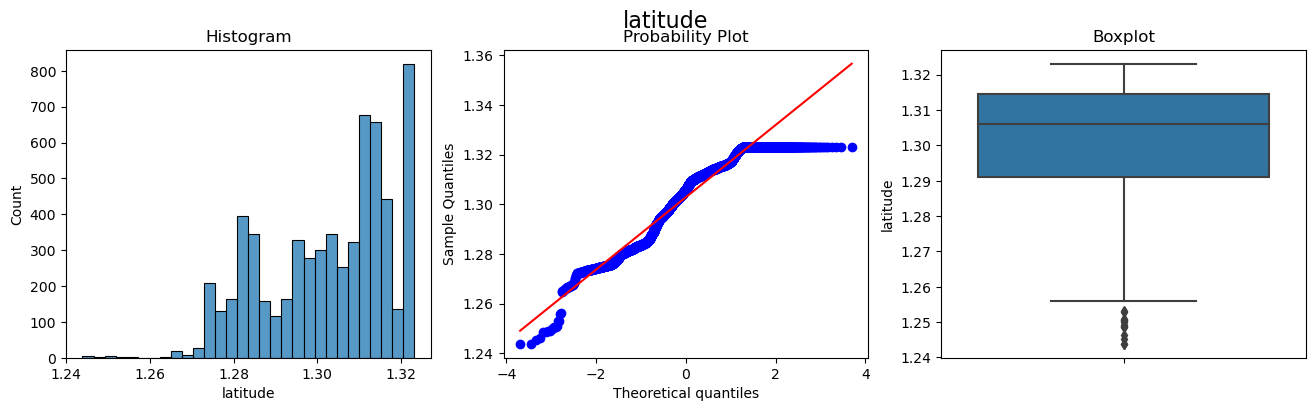

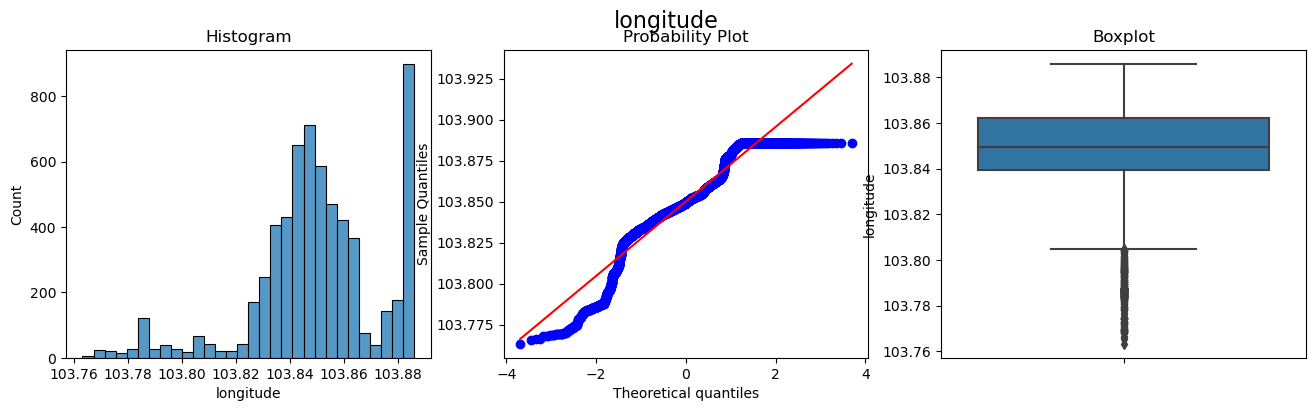

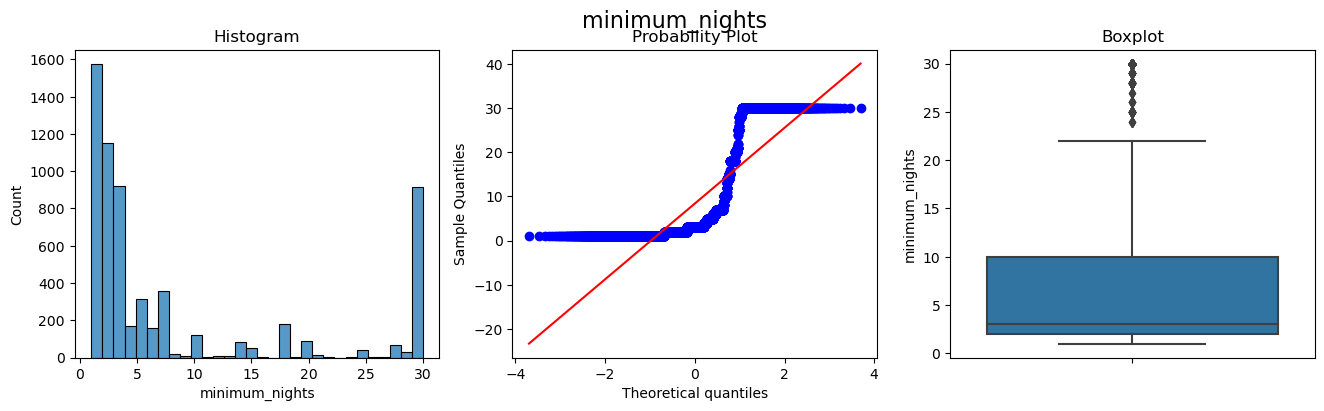

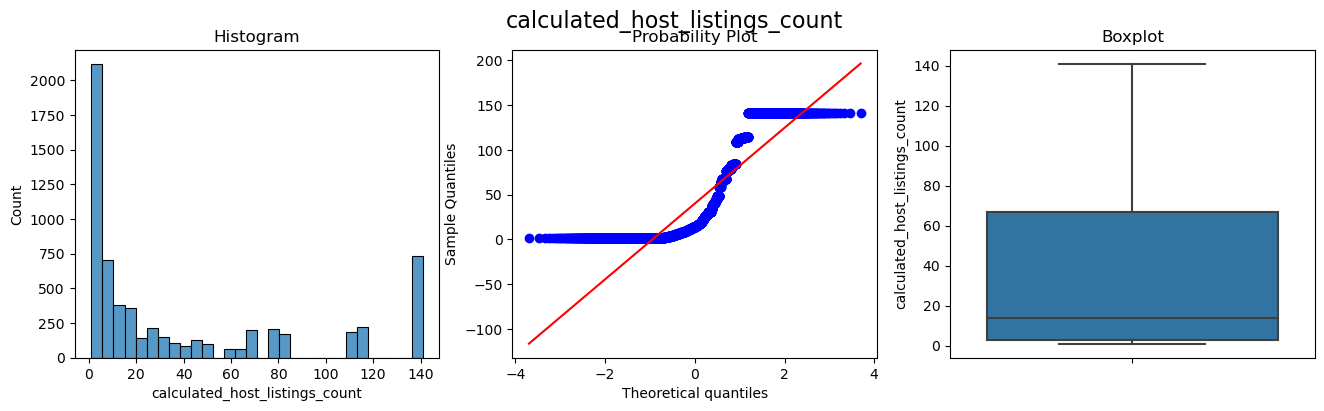

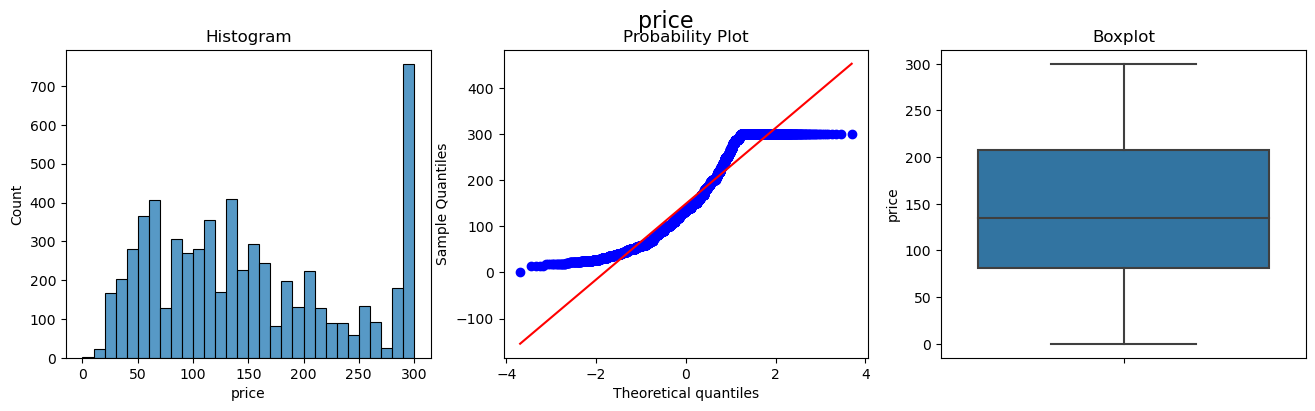

In [130]:
# diagnostic_plot (after handling)
diagnostic_plots(bnb_data_o, 'latitude') # handle
diagnostic_plots(bnb_data_o, 'longitude')# handle
diagnostic_plots(bnb_data_o, 'minimum_nights') # handle
diagnostic_plots(bnb_data_o, 'calculated_host_listings_count') # handle
diagnostic_plots(bnb_data_o, 'price') # target

#### Drop Irrelevant Features

In [131]:
# Remove features ('name', 'id', 'host_id', 'last_review', 'host_name') (based on exploratory analysis)
bnb_data_d = bnb_data_o.drop(labels = ['name', 'id', 'host_id', 'last_review','reviews_per_month','host_name', 'neighbourhood_group'], axis = 1)

#### Train Test Split

In [132]:
# Train Test Split
# Split the dataset into training (70%) and testing (30%)
# Target variable: Item_Outlet_Sales
bnb_X_train, bnb_X_test, bnb_y_train, bnb_y_test = train_test_split(
    bnb_data_d.drop(labels=['price'], axis=1),  # predictors
    bnb_data_d['price'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=45)  # seed ensures reproducibility (87 & 45)

bnb_X_train.shape, bnb_X_test.shape

((4416, 8), (1893, 8))

#### Numerical Transformation

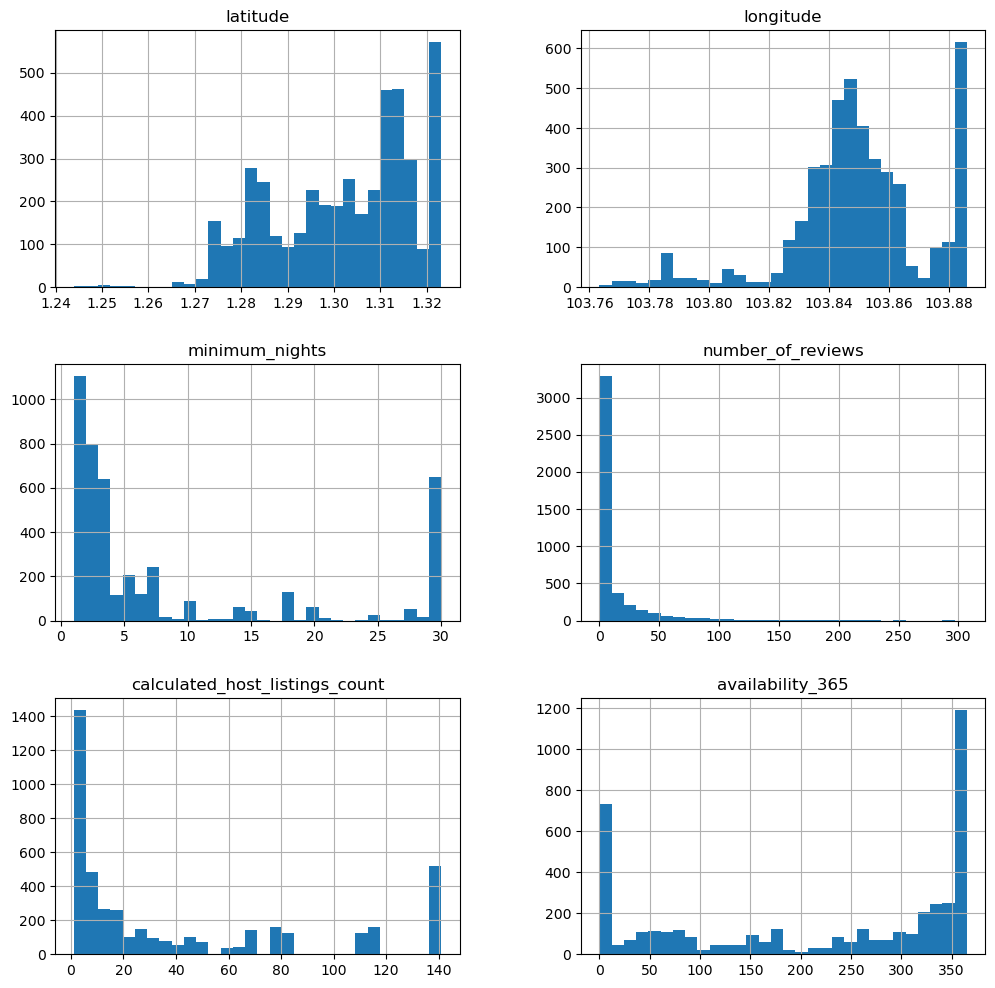

In [133]:
# Numerical Transformation
bnb_X_train.hist(bins=30, figsize=(12,12))
plt.show()

In [134]:
# Check Negative values (decide transformer)
num_cols = [c for c in bnb_X_train.columns if bnb_X_train[c].dtypes !='O']
(bnb_X_train[num_cols] < 0).values.any()

False

In [135]:
# Numerical Transformation (Power Transformer)

t = PowerTransformer(variables= ['minimum_nights', 'number_of_reviews'
                                ,'calculated_host_listings_count', 'availability_365', 'latitude', 'longitude'], exp = 1/3)

#t = YeoJohnsonTransformer(variables= ['minimum_nights', 'number_of_reviews'
#                                 ,'calculated_host_listings_count', 'availability_365'])
# causes inf values
#t = BoxCoxTransformer(variables= ['minimum_nights', 'number_of_reviews'
#                                 ,'calculated_host_listings_count', 'availability_365'])
# negative values or constant are present


# fit transformer to data set
t.fit(bnb_X_train)

# transform on train and test
bnb_X_train_nt = t.transform(bnb_X_train)
bnb_X_test_nt = t.transform(bnb_X_test)


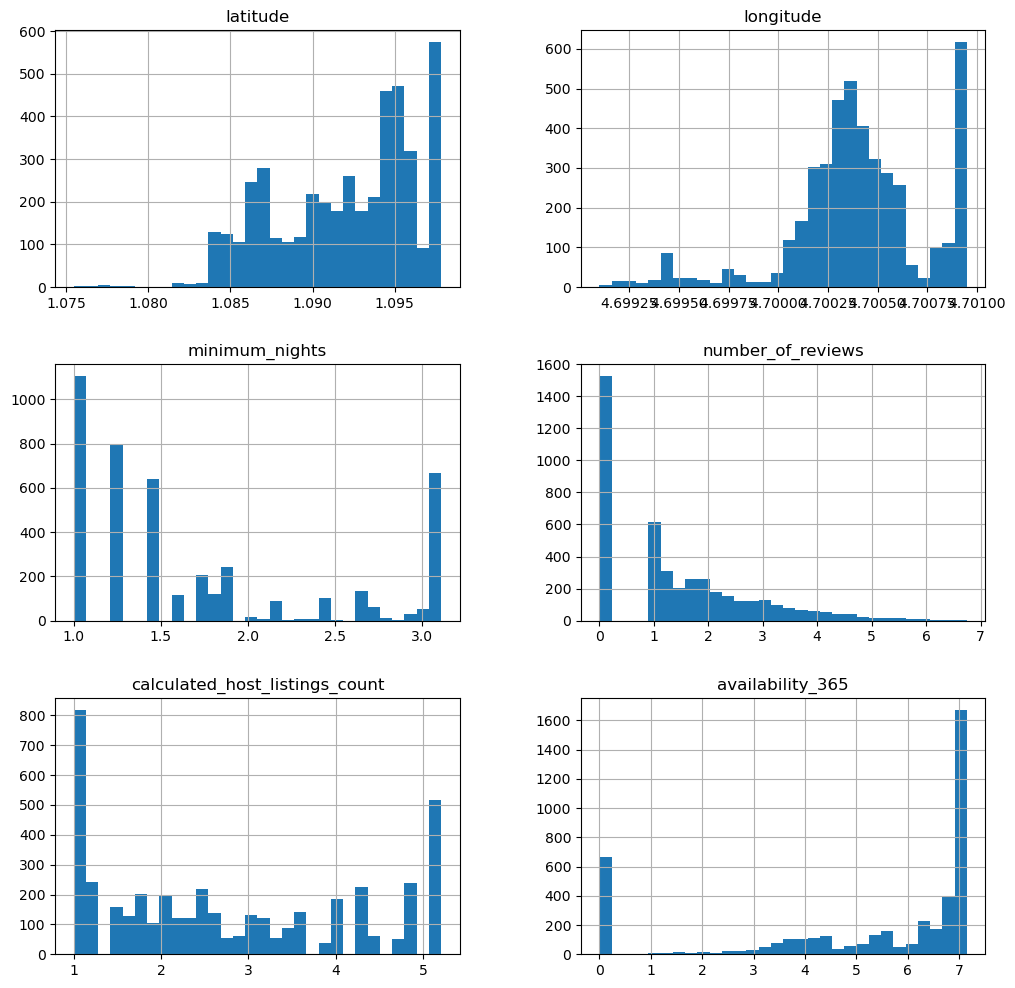

In [136]:
# observe distribution
bnb_X_train_nt.hist(bins=30, figsize=(12,12))
plt.show()

In [137]:
# Check Values
num_cols = [c for c in bnb_X_train_nt.columns if bnb_X_train_nt[c].dtypes !='O']
bnb_X_train_nt[num_cols].head()

latitude  longitude  minimum_nights  number_of_reviews  \
3872  1.090612   4.700504        1.000000           2.351335   
4859  1.094510   4.700589        1.000000           1.817121   
3791  1.097482   4.700641        1.912931           1.259921   
403   1.095683   4.700069        1.912931           2.410142   
3382  1.094885   4.700891        1.259921           3.732511   

      calculated_host_listings_count  availability_365  
3872                        2.080084          4.805896  
4859                        4.000000          7.146569  
3791                        4.848808          6.938232  
403                         2.668402          0.000000  
3382                        2.080084          5.253588

In [138]:
# Note that the values are alread scaled well.
# May not have to utilize feature scaling

#### Categorical Transformation

In [139]:
# One-Hot Encoding
ohe_enc = OneHotEncoder(drop_last=False)

In [140]:
ohe_enc.fit(bnb_X_train_nt)

OneHotEncoder()

In [141]:
bnb_X_train_enc = ohe_enc.transform(bnb_X_train_nt)
bnb_X_test_enc = ohe_enc.transform(bnb_X_test_nt)

In [142]:
bnb_X_train_enc.head()

latitude  longitude  minimum_nights  number_of_reviews  \
3872  1.090612   4.700504        1.000000           2.351335   
4859  1.094510   4.700589        1.000000           1.817121   
3791  1.097482   4.700641        1.912931           1.259921   
403   1.095683   4.700069        1.912931           2.410142   
3382  1.094885   4.700891        1.259921           3.732511   

      calculated_host_listings_count  availability_365  \
3872                        2.080084          4.805896   
4859                        4.000000          7.146569   
3791                        4.848808          6.938232   
403                         2.668402          0.000000   
3382                        2.080084          5.253588   

      neighbourhood_Downtown Core  neighbourhood_Kallang  \
3872                            1                      0   
4859                            0                      1   
3791                            0                      1   
403                             0                      0   
3382                            0                      0   

      neighbourhood_Tanglin  neighbourhood_Geylang  ...  \
3872                      0                      0  ...   
4859                      0                      0  ...   
3791                      0                      0  ...   
403                       1                      0  ...   
3382                      0                      1  ...   

      neighbourhood_Toa Payoh  neighbourhood_Bukit Timah  \
3872                        0                          0   
4859                        0                          0   
3791                        0                          0   
403                         0                          0   
3382                        0                          0   

      neighbourhood_Newton  neighbourhood_Marine Parade  \
3872                     0                            0   
4859                     0                            0   
3791                     0                            0   
403                      0                            0   
3382                     0                            0   

      neighbourhood_Southern Islands  neighbourhood_Bishan  \
3872                               0                     0   
4859                               0                     0   
3791                               0                     0   
403                                0                     0   
3382                               0                     0   

      neighbourhood_Marina South  room_type_Shared room  \
3872                           0                      1   
4859                           0                      0   
3791                           0                      0   
403                            0                      0   
3382                           0                      0   

      room_type_Private room  room_type_Entire home/apt  
3872                       0                          0  
4859                       1                          0  
3791                       0                          1  
403                        0                          1  
3382                       1                          0  

[5 rows x 29 columns]

In [143]:
bnb_X_test_enc.head()

latitude  longitude  minimum_nights  number_of_reviews  \
6301  1.095049   4.700950        1.442250           1.000000   
4610  1.095094   4.700879        1.259921           3.141381   
2870  1.091578   4.699656        1.259921           1.442250   
2025  1.094518   4.700574        1.000000           2.843867   
5882  1.093139   4.700364        1.442250           0.000000   

      calculated_host_listings_count  availability_365  \
6301                        4.834588          7.146569   
4610                        1.442250          5.325074   
2870                        1.000000          0.000000   
2025                        2.519842          7.054004   
5882                        5.204828          6.231680   

      neighbourhood_Downtown Core  neighbourhood_Kallang  \
6301                            0                      0   
4610                            0                      0   
2870                            0                      0   
2025                            0                      1   
5882                            0                      0   

      neighbourhood_Tanglin  neighbourhood_Geylang  ...  \
6301                      0                      1  ...   
4610                      0                      1  ...   
2870                      0                      0  ...   
2025                      0                      0  ...   
5882                      0                      0  ...   

      neighbourhood_Toa Payoh  neighbourhood_Bukit Timah  \
6301                        0                          0   
4610                        0                          0   
2870                        0                          0   
2025                        0                          0   
5882                        0                          0   

      neighbourhood_Newton  neighbourhood_Marine Parade  \
6301                     0                            0   
4610                     0                            0   
2870                     0                            0   
2025                     0                            0   
5882                     1                            0   

      neighbourhood_Southern Islands  neighbourhood_Bishan  \
6301                               0                     0   
4610                               0                     0   
2870                               0                     0   
2025                               0                     0   
5882                               0                     0   

      neighbourhood_Marina South  room_type_Shared room  \
6301                           0                      0   
4610                           0                      0   
2870                           0                      0   
2025                           0                      0   
5882                           0                      0   

      room_type_Private room  room_type_Entire home/apt  
6301                       0                          1  
4610                       0                          1  
2870                       1                          0  
2025                       0                          1  
5882                       0                          1  

[5 rows x 29 columns]

#### Feature Scaling (not Implemented)

In [144]:
# Feature Scaling 
# Not implemented as values are already fairly scaled and scaling may lead to overfitting as model becomes too complex.
# scaler = StandardScaler()

# fit the scaler to the train set, it will learn the parameters
#scaler.fit(bnb_X_train_enc)

# transform train and test sets
#X_train_final = scaler.transform(bnb_X_train_enc)
#X_test_final = scaler.transform(bnb_X_test_enc)

# Set to final train test for modelling.
X_train_final = bnb_X_train_enc
X_test_final = bnb_X_test_enc
X_train_final.shape, X_test_final.shape

((4416, 29), (1893, 29))

In [145]:
#X_train_final = pd.DataFrame(X_train_final, columns=bnb_X_train_enc.columns)
#X_test_final = pd.DataFrame(X_test_final, columns=bnb_X_train_enc.columns)

In [146]:
# Check Final Rows

In [147]:
X_train_final.head()

latitude  longitude  minimum_nights  number_of_reviews  \
3872  1.090612   4.700504        1.000000           2.351335   
4859  1.094510   4.700589        1.000000           1.817121   
3791  1.097482   4.700641        1.912931           1.259921   
403   1.095683   4.700069        1.912931           2.410142   
3382  1.094885   4.700891        1.259921           3.732511   

      calculated_host_listings_count  availability_365  \
3872                        2.080084          4.805896   
4859                        4.000000          7.146569   
3791                        4.848808          6.938232   
403                         2.668402          0.000000   
3382                        2.080084          5.253588   

      neighbourhood_Downtown Core  neighbourhood_Kallang  \
3872                            1                      0   
4859                            0                      1   
3791                            0                      1   
403                             0                      0   
3382                            0                      0   

      neighbourhood_Tanglin  neighbourhood_Geylang  ...  \
3872                      0                      0  ...   
4859                      0                      0  ...   
3791                      0                      0  ...   
403                       1                      0  ...   
3382                      0                      1  ...   

      neighbourhood_Toa Payoh  neighbourhood_Bukit Timah  \
3872                        0                          0   
4859                        0                          0   
3791                        0                          0   
403                         0                          0   
3382                        0                          0   

      neighbourhood_Newton  neighbourhood_Marine Parade  \
3872                     0                            0   
4859                     0                            0   
3791                     0                            0   
403                      0                            0   
3382                     0                            0   

      neighbourhood_Southern Islands  neighbourhood_Bishan  \
3872                               0                     0   
4859                               0                     0   
3791                               0                     0   
403                                0                     0   
3382                               0                     0   

      neighbourhood_Marina South  room_type_Shared room  \
3872                           0                      1   
4859                           0                      0   
3791                           0                      0   
403                            0                      0   
3382                           0                      0   

      room_type_Private room  room_type_Entire home/apt  
3872                       0                          0  
4859                       1                          0  
3791                       0                          1  
403                        0                          1  
3382                       1                          0  

[5 rows x 29 columns]

In [148]:
X_test_final.head()

latitude  longitude  minimum_nights  number_of_reviews  \
6301  1.095049   4.700950        1.442250           1.000000   
4610  1.095094   4.700879        1.259921           3.141381   
2870  1.091578   4.699656        1.259921           1.442250   
2025  1.094518   4.700574        1.000000           2.843867   
5882  1.093139   4.700364        1.442250           0.000000   

      calculated_host_listings_count  availability_365  \
6301                        4.834588          7.146569   
4610                        1.442250          5.325074   
2870                        1.000000          0.000000   
2025                        2.519842          7.054004   
5882                        5.204828          6.231680   

      neighbourhood_Downtown Core  neighbourhood_Kallang  \
6301                            0                      0   
4610                            0                      0   
2870                            0                      0   
2025                            0                      1   
5882                            0                      0   

      neighbourhood_Tanglin  neighbourhood_Geylang  ...  \
6301                      0                      1  ...   
4610                      0                      1  ...   
2870                      0                      0  ...   
2025                      0                      0  ...   
5882                      0                      0  ...   

      neighbourhood_Toa Payoh  neighbourhood_Bukit Timah  \
6301                        0                          0   
4610                        0                          0   
2870                        0                          0   
2025                        0                          0   
5882                        0                          0   

      neighbourhood_Newton  neighbourhood_Marine Parade  \
6301                     0                            0   
4610                     0                            0   
2870                     0                            0   
2025                     0                            0   
5882                     1                            0   

      neighbourhood_Southern Islands  neighbourhood_Bishan  \
6301                               0                     0   
4610                               0                     0   
2870                               0                     0   
2025                               0                     0   
5882                               0                     0   

      neighbourhood_Marina South  room_type_Shared room  \
6301                           0                      0   
4610                           0                      0   
2870                           0                      0   
2025                           0                      0   
5882                           0                      0   

      room_type_Private room  room_type_Entire home/apt  
6301                       0                          1  
4610                       0                          1  
2870                       1                          0  
2025                       0                          1  
5882                       0                          1  

[5 rows x 29 columns]

### 2.3 Correlation Analysis

In [149]:
# Inspect Correlation of features
X_train_final.corr()

latitude  longitude  minimum_nights  \
latitude                        1.000000   0.386530       -0.041574   
longitude                       0.386530   1.000000       -0.067841   
minimum_nights                 -0.041574  -0.067841        1.000000   
number_of_reviews               0.004845   0.077660       -0.265411   
calculated_host_listings_count  0.093734   0.170591        0.293924   
availability_365                0.017693   0.032006        0.199031   
neighbourhood_Downtown Core    -0.402393  -0.010858        0.150777   
neighbourhood_Kallang           0.305174   0.199726        0.040613   
neighbourhood_Tanglin          -0.003723  -0.182370       -0.035088   
neighbourhood_Geylang           0.306730   0.610551       -0.071996   
neighbourhood_River Valley     -0.105300  -0.131276       -0.033447   
neighbourhood_Queenstown       -0.155261  -0.523977        0.061969   
neighbourhood_Singapore River  -0.156979  -0.040135       -0.076832   
neighbourhood_Rochor            0.035763   0.030545       -0.120208   
neighbourhood_Novena            0.380232  -0.015368        0.065163   
neighbourhood_Outram           -0.379827  -0.077615        0.044677   
neighbourhood_Orchard           0.005853  -0.090312       -0.069749   
neighbourhood_Museum           -0.038533  -0.021785       -0.000163   
neighbourhood_Bukit Merah      -0.394646  -0.242446       -0.009683   
neighbourhood_Toa Payoh         0.177732   0.057981        0.028411   
neighbourhood_Bukit Timah       0.156343  -0.373573        0.035736   
neighbourhood_Newton            0.040905  -0.068388       -0.001765   
neighbourhood_Marine Parade     0.027326   0.251191       -0.034709   
neighbourhood_Southern Islands -0.198753  -0.054692       -0.002236   
neighbourhood_Bishan            0.129277  -0.037479        0.015087   
neighbourhood_Marina South     -0.018101   0.007507       -0.014701   
room_type_Shared room          -0.081080  -0.028089       -0.209410   
room_type_Private room         -0.011652  -0.066789        0.000197   
room_type_Entire home/apt       0.048912   0.077927        0.096892   

                                number_of_reviews  \
latitude                                 0.004845   
longitude                                0.077660   
minimum_nights                          -0.265411   
number_of_reviews                        1.000000   
calculated_host_listings_count          -0.214132   
availability_365                        -0.020433   
neighbourhood_Downtown Core             -0.014571   
neighbourhood_Kallang                   -0.025607   
neighbourhood_Tanglin                   -0.002951   
neighbourhood_Geylang                    0.036252   
neighbourhood_River Valley               0.072298   
neighbourhood_Queenstown                -0.064558   
neighbourhood_Singapore River           -0.040381   
neighbourhood_Rochor                     0.041234   
neighbourhood_Novena                    -0.071753   
neighbourhood_Outram                     0.031384   
neighbourhood_Orchard                    0.059782   
neighbourhood_Museum                     0.035784   
neighbourhood_Bukit Merah               -0.065692   
neighbourhood_Toa Payoh                 -0.008325   
neighbourhood_Bukit Timah               -0.015606   
neighbourhood_Newton                     0.007913   
neighbourhood_Marine Parade              0.088002   
neighbourhood_Southern Islands          -0.025231   
neighbourhood_Bishan                    -0.026237   
neighbourhood_Marina South               0.000400   
room_type_Shared room                    0.023106   
room_type_Private room                   0.015087   
room_type_Entire home/apt               -0.025373   

                                calculated_host_listings_count  \
latitude                                              0.093734   
longitude                                             0.170591   
minimum_nights                                        0.293924   
number_of_reviews                             

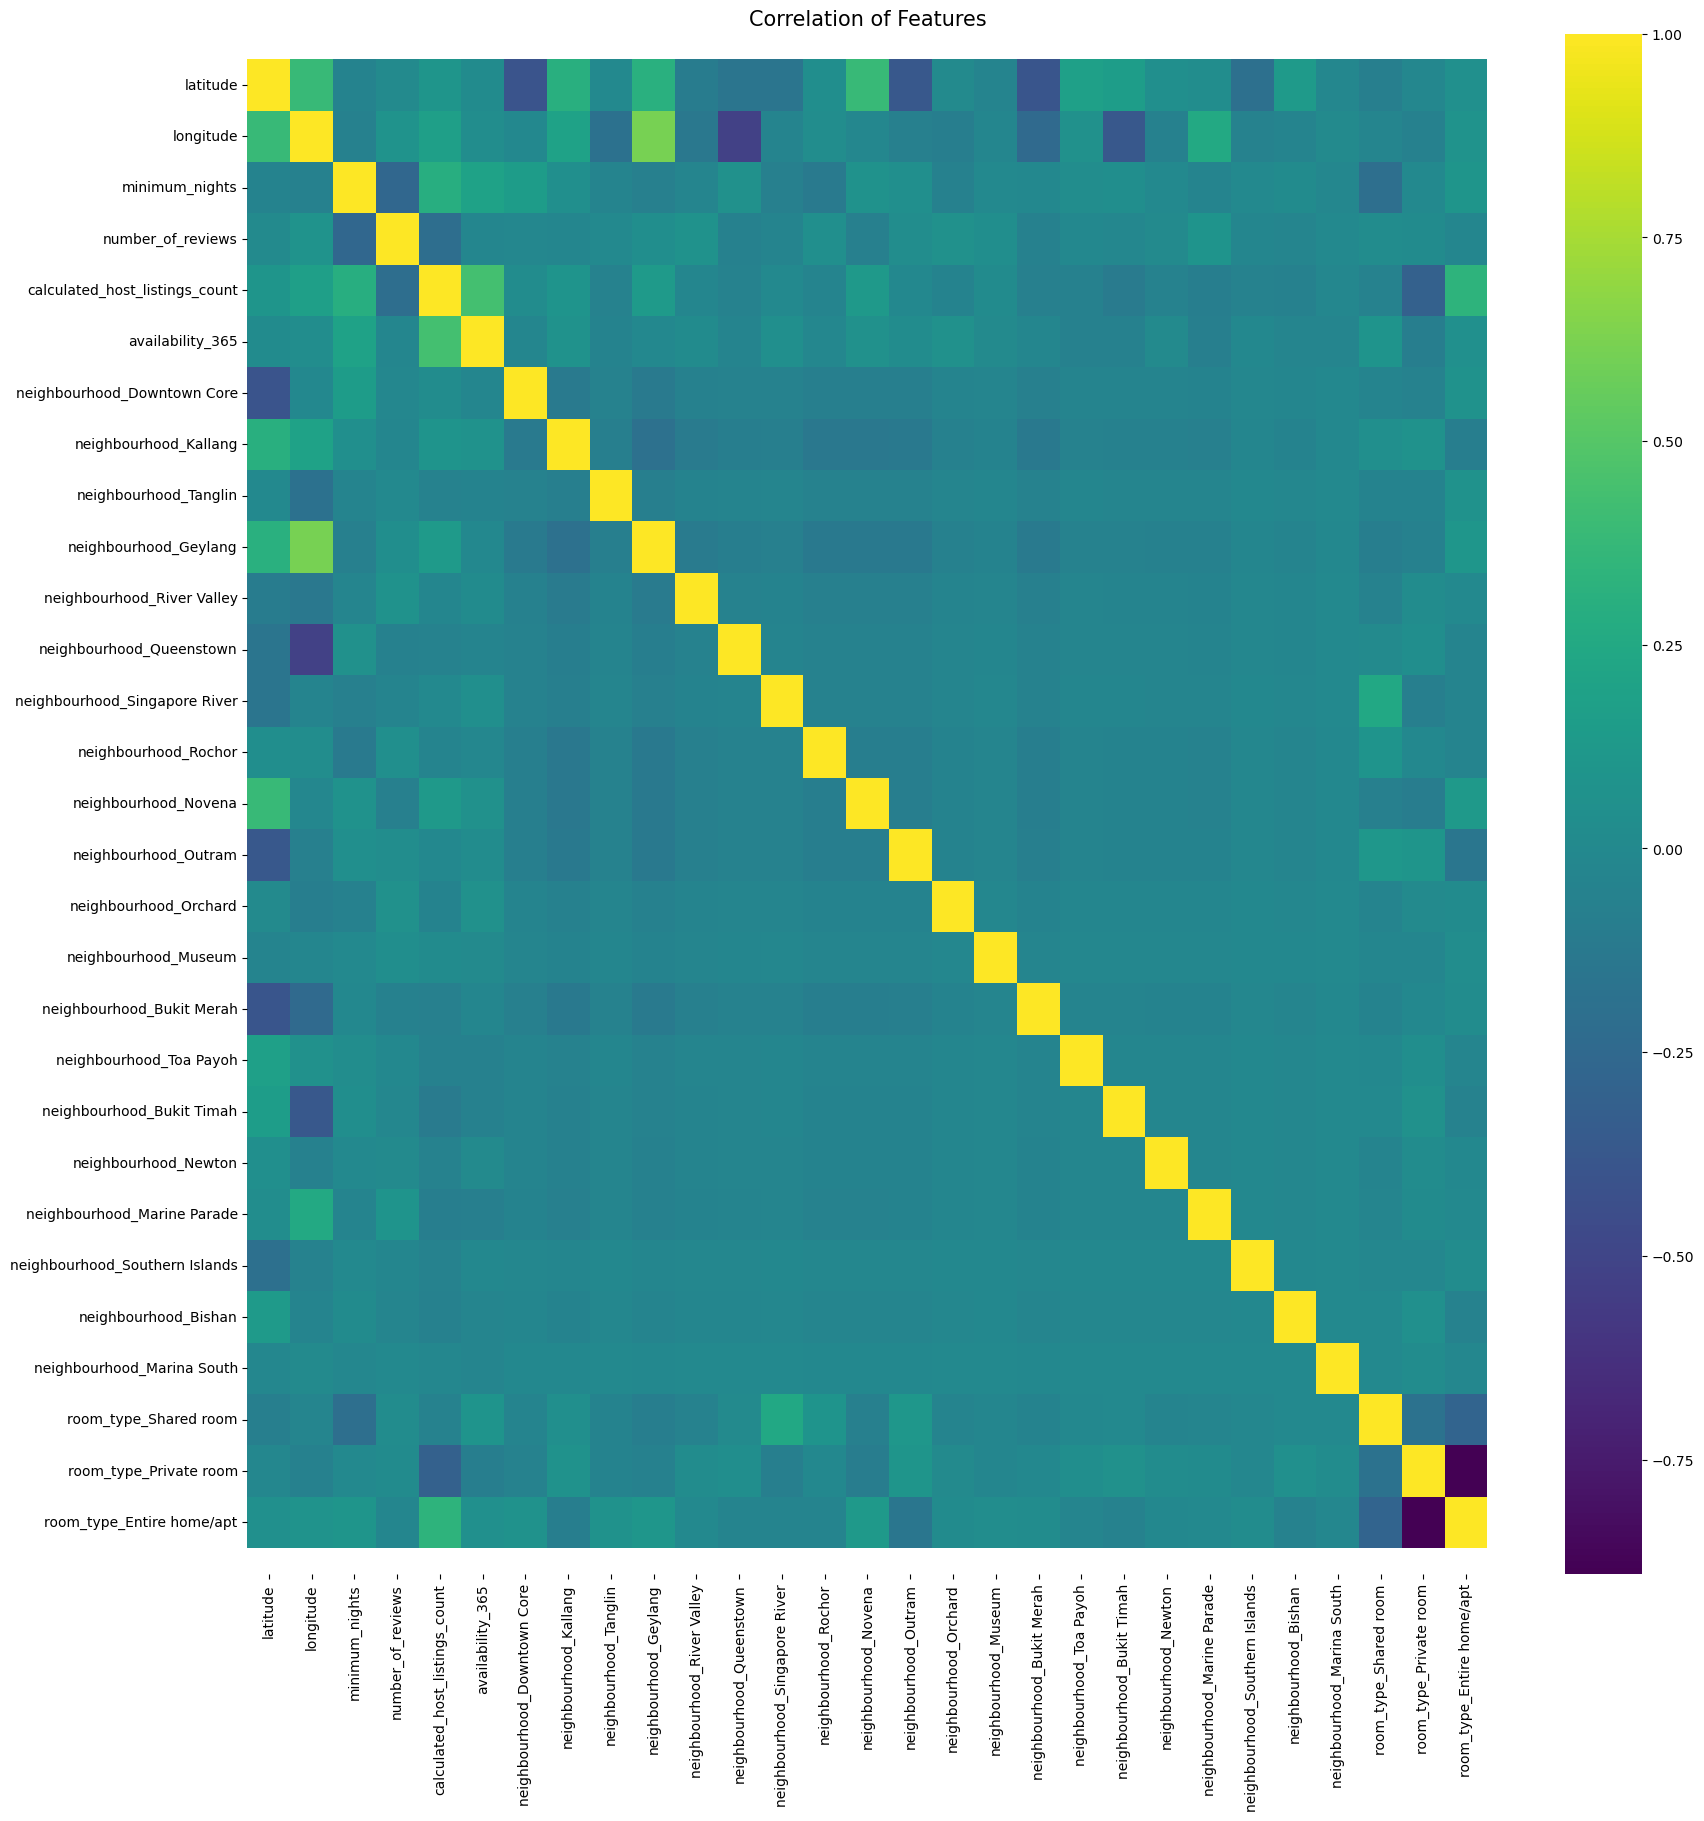

In [150]:
# Build a heatmap to visualize correlation
colormap = plt.cm.viridis
plt.figure(figsize=(20,20))
plt.title('Correlation of Features', size=15)
ax = sns.heatmap(X_train_final.corr(), cmap=colormap, annot=False)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

#### Testing data on model (Linear Regression)

In [151]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

linreg = LinearRegression()
linreg.fit(X_train_final, bnb_y_train)

LinearRegression()

In [152]:
print(linreg.coef_) # gradient
print(linreg.intercept_) # y-intercept

[-4.94023990e+02 -6.00327357e+04 -2.44129156e+01 -9.21722759e+00
 -4.88106518e+00  6.14110359e+00  1.65238639e+01 -6.42503025e+00
 -2.61915798e+01  5.12314574e+00 -3.17406730e+01 -7.00530459e+01
 -7.82395787e+00 -5.00384220e+00 -1.47867498e+01 -1.72350336e+01
  2.27391325e+01  1.04288294e+01 -5.72849648e+01 -1.57868149e+01
 -5.95585532e+01 -1.73752615e+01  1.73734223e+01  6.68315272e+01
 -1.87245892e+01  2.08970175e+02 -7.93441718e+01 -1.21229949e+01
  9.14671667e+01]
282872.822336313


In [153]:
y_fitted = linreg.predict(X_train_final)

# Calculated the RMSE and R^2 for training set
print(sqrt(mean_squared_error(y_fitted, bnb_y_train)), '(Train RMSE)') # RMSE: the lower the better
print(linreg.score(X_train_final, bnb_y_train), '(Train R^2 Value)') # R squared value (ranges from 0 to 1): the higher the better

62.198698155792066 (Train RMSE)
0.4784326969473981 (Train R^2 Value)


In [154]:
y_pred = linreg.predict(X_test_final)

# Calculated the RMSE and R^2 for testing set
print(sqrt(mean_squared_error(y_pred, bnb_y_test)), '(Test RMSE)') # RMSE: the lower the better
print(linreg.score(X_test_final, bnb_y_test), '(Test R^2 Value)') # R squared value (ranges from 0 to 1): the higher the better

60.75901503680471 (Test RMSE)
0.473001558171919 (Test R^2 Value)


In [155]:
predicts = linreg.predict(X_test_final)
error_airbnb = pd.DataFrame({
        'Actual Values': np.array(bnb_y_test).flatten(),
        'Predicted Values': predicts.flatten()})
error_airbnb.head()

Actual Values  Predicted Values
0          237.0        193.423669
1          178.0        187.734438
2           51.0         69.218498
3          208.0        209.200162
4          169.0        208.798967

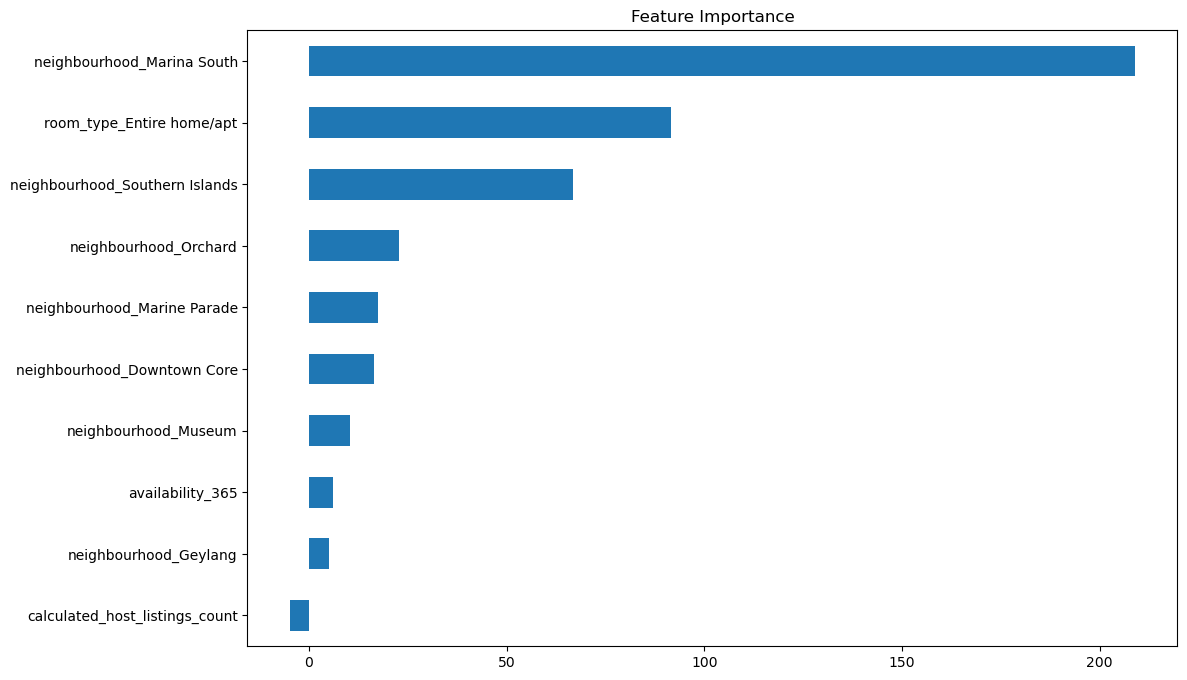

In [156]:
# Showing Features Importance (Top 10)
importance = linreg.coef_
index=X_test_final.columns

# Feature Importance as a Plot
feature_importance = pd.Series(importance, index = index)
feature_importance.nlargest(10).sort_values(ascending = True).plot(kind='barh',title = 'Feature Importance',figsize=(12,8)) # Top 10
plt.show()

In [157]:
# Feature Importance as Dataframe
f_imp_df2 = feature_importance.to_frame(name='Feature Importance')
f_imp_df2.head(10).sort_values(by='Feature Importance', ascending = True)

Feature Importance
longitude                            -60032.735695
latitude                               -494.023990
neighbourhood_Tanglin                   -26.191580
minimum_nights                          -24.412916
number_of_reviews                        -9.217228
neighbourhood_Kallang                    -6.425030
calculated_host_listings_count           -4.881065
neighbourhood_Geylang                     5.123146
availability_365                          6.141104
neighbourhood_Downtown Core              16.523864

In [158]:
# All Features
f_imp_df2

Feature Importance
latitude                               -494.023990
longitude                            -60032.735695
minimum_nights                          -24.412916
number_of_reviews                        -9.217228
calculated_host_listings_count           -4.881065
availability_365                          6.141104
neighbourhood_Downtown Core              16.523864
neighbourhood_Kallang                    -6.425030
neighbourhood_Tanglin                   -26.191580
neighbourhood_Geylang                     5.123146
neighbourhood_River Valley              -31.740673
neighbourhood_Queenstown                -70.053046
neighbourhood_Singapore River            -7.823958
neighbourhood_Rochor                     -5.003842
neighbourhood_Novena                    -14.786750
neighbourhood_Outram                    -17.235034
neighbourhood_Orchard                    22.739133
neighbourhood_Museum                     10.428829
neighbourhood_Bukit Merah               -57.284965
neighbourhood_Toa Payoh                 -15.786815
neighbourhood_Bukit Timah               -59.558553
neighbourhood_Newton                    -17.375262
neighbourhood_Marine Parade              17.373422
neighbourhood_Southern Islands           66.831527
neighbourhood_Bishan                    -18.724589
neighbourhood_Marina South              208.970175
room_type_Shared room                   -79.344172
room_type_Private room                  -12.122995
room_type_Entire home/apt                91.467167

In [159]:
# Evaluate Coef of features
lm2 = sm.OLS(bnb_y_train, X_train_final).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                     149.1
Date:                Sat, 17 Dec 2022   Prob (F-statistic):               0.00
Time:                        23:00:30   Log-Likelihood:                -24506.
No. Observations:                4416   AIC:                         4.907e+04
Df Residuals:                    4388   BIC:                         4.925e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
latitude                        -494.0240    673.822     -0.733      0.463   -1815.055     827.007
longitude                      -6.003e+04   1.11e+04     -5.401      0.000   -8.18e+04   -3.82e+04
minimum_nights                   -24.4129      1.435    -17.013      0.000     -27.226     -21.600
number_of_reviews                 -9.2172      0.734    -12.551      0.000     -10.657      -7.777
calculated_host_listings_count    -4.8811      0.821     -5.944      0.000      -6.491      -3.271
availability_365                   6.1411      0.430     14.293      0.000       5.299       6.983
neighbourhood_Downtown Core     3.691e+04   6814.691      5.417      0.000    2.36e+04    5.03e+04
neighbourhood_Kallang           3.689e+04   6816.639      5.412      0.000    2.35e+04    5.03e+04
neighbourhood_Tanglin           3.687e+04   6810.996      5.413      0.000    2.35e+04    5.02e+04
neighbourhood_Geylang            3.69e+04   6820.458      5.410      0.000    2.35e+04    5.03e+04
neighbourhood_River Valley      3.686e+04   6812.858      5.411      0.000    2.35e+04    5.02e+04
neighbourhood_Queenstown        3.683e+04   6804.969      5.412      0.000    2.35e+04    5.02e+04
neighbourhood_Singapore River   3.689e+04   6813.932      5.414      0.000    2.35e+04    5.02e+04
neighbourhood_Rochor            3.689e+04   6815.260      5.413      0.000    2.35e+04    5.03e+04
neighbourhood_Novena            3.688e+04   6814.665      5.412      0.000    2.35e+04    5.02e+04
neighbourhood_Outram            3.688e+04   6813.824      5.412      0.000    2.35e+04    5.02e+04
neighbourhood_Orchard           3.692e+04   6812.493      5.419      0.000    2.36e+04    5.03e+04
neighbourhood_Museum            3.691e+04   6814.042      5.416      0.000    2.35e+04    5.03e+04
neighbourhood_Bukit Merah       3.684e+04   6811.522      5.408      0.000    2.35e+04    5.02e+04
neighbourhood_Toa Payoh         3.688e+04   6816.620      5.410      0.000    2.35e+04    5.02e+04
neighbourhood_Bukit Timah       3.684e+04   6804.665      5.413      0.000    2.35e+04    5.02e+04
neighbourhood_Newton            3.688e+04   6813.080      5.413      0.000    2.35e+04    5.02e+04
neighbourhood_Marine Parade     3.691e+04   6820.911      5.412      0.000    2.35e+04    5.03e+04
neighbourhood_Southern Islands  3.696e+04   6811.066      5.427      0.000    2.36e+04    5.03e+04
neighbourhood_Bishan            3.688e+04   6813.381      5.413      0.000    2.35e+04    5.02e+04
neighbourhood_Marina South      3.711e+04   6817.173      5.443      0.000    2.37e+04    5.05e+04
room_type_Shared room           2.459e+05   4.54e+04      5.413      0.000    1.57e+05    3.35e+05
room_type_Private room           2.46e+05   4.54e+04      5.415      0.000    1.57e+05    3.35e+05
room_type_Enti

### 2.4 Export the data

In [160]:
# Combine Target and Predictors
train=pd.concat([X_train_final,bnb_y_train],axis=1)
test=pd.concat([X_test_final,bnb_y_test],axis=1)
# Combine Train and Test sets
bnb_data=pd.concat([train,test],axis=0)
# Write to new excel file
bnb_data.to_csv('listings_new.csv', encoding='utf-8', index=False)